In [1]:
%pip install astroquery
from astroquery.gaia import Gaia 
from astroquery.utils.tap.core import TapPlus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import read_mist_models
import corner

Note: you may need to restart the kernel to use updated packages.


## RR Lyrae Catalog Download

In [52]:
query = """
SELECT TOP 100 
    solution_id, 
    source_id, 
    pf, 
    pf_error, 
    num_clean_epochs_g
FROM 
    gaiadr3.vari_rrlyrae
WHERE 
    pf IS NOT NULL AND num_clean_epochs_g > 40
"""

job = Gaia.launch_job_async(query)
results = job.get_results()
print(results[:10])

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
   solution_id         source_id      ...    pf_error   num_clean_epochs_g
                                      ...       d                         
------------------ ------------------ ... ------------- ------------------
375316653866487565 245002531050576896 ... 5.9112863e-06                 45
375316653866487565 245504251951140864 ...  3.948115e-06                 62
375316653866487565 245823861938360064 ... 3.0187648e-06                 59
375316653866487565 246756973652292992 ...  2.743857e-06                 55
375316653866487565 359112665277840512 ... 2.8541435e-06                 51
375316653866487565 414003442535159936 ... 3.1032864e-06                 82
375316653866487565 414081061185873792 ... 3.1364334e-06                 82
375316653866487565 414152842984521856 ...  1.611218e-05                 69
375316653866487565 414254032403091072 ...  4.310351e-06                 62
375316653866487565 415000566440590976 ... 3.599676

## Light Curve Retrieval

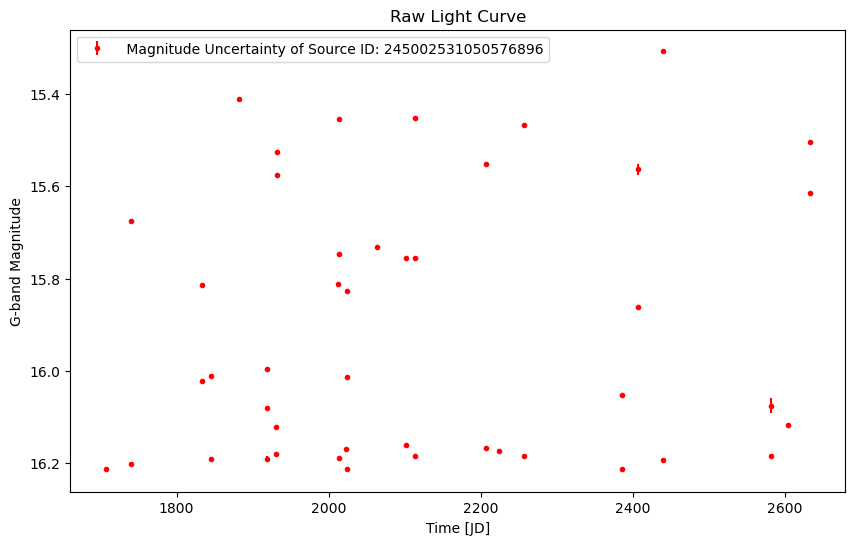

In [55]:
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'COMBINED'     
data_release   = 'Gaia DR3'    


datalink  = Gaia.load_data(ids=results['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]

dl_key      = 'EPOCH_PHOTOMETRY_COMBINED.xml'     
product     = datalink[dl_key][0]
product_tb  = product.to_table() # Exporting to Astropy Table object.

mag_error = 2.5 / np.log(10) * (product_tb['flux_error'] / product_tb['flux'])

# Adding the calculated mag_error as a new column to the table
product_tb['mag_error'] = mag_error


g_band_rows = product_tb[product_tb['band'] == 'G']


source_ids = [row['source_id'] for row in results]  # Detects source_ids.

example_source_id = source_ids[0]  

# Filtering for the specific source_id
specific_source_data = [row for row in g_band_rows if row['source_id'] == example_source_id]

# Plotting 1 Light Curve

plt.figure(figsize=(10, 6))
plt.errorbar([row['time'] for row in specific_source_data], 
             [row['mag'] for row in specific_source_data],
             yerr=[row['mag_error'] for row in specific_source_data],
             fmt='o', color='red', markersize = 3, label=f' Magnitude Uncertainty of Source ID: {example_source_id}')

plt.gca().invert_yaxis()
plt.xlabel('Time [JD]')
plt.ylabel('G-band Magnitude')
plt.title('Raw Light Curve')
plt.legend()
plt.show()

## Period and Mean Magnitude Estimation

In [50]:
from astropy.timeseries import LombScargle
from astropy.table import Table, Column

list_mag = []
list_period = []

results_df = pd.DataFrame(columns=['Source ID', 'Estimated Period', 'Mean Magnitude'])

for source_id in source_ids[:100]:  

    current_data = g_band_rows[g_band_rows['source_id'] == source_id]

    time = current_data['time'].data
    flux = current_data['flux']
    flux_error = current_data['flux_error']
    
    # Converting flux to magnitude 
    mag = -2.5 * np.log10(flux) + 25  
    
    # Estimating the period using Lomb-Scargle periodogram
    ls = LombScargle(time, mag)
    frequency, power = ls.autopower(minimum_frequency =1, maximum_frequency = (1/0.3))

    
    best_frequency = frequency[np.argmax(power)]
    best_period = 1 / best_frequency

    
    # Calculating mean magnitude
    mean_flux = np.mean(flux)
    mean_mag = -2.5 * np.log10(mean_flux) + 25 


    list_mag.append(mean_mag)
    list_period.append(best_period)


frequency_values = [freq.value for freq in list_period]

#Creating columns for the table
source_id_col = Column(name='source_id', data=source_ids)
mag_col = Column(name='mean_mag', data=list_mag)
period_col = Column(name='period', data=frequency_values)


# Creating the table
data_table = Table([source_id_col, period_col, mag_col])

print(data_table)

     source_id             period            mean_mag     
------------------- ------------------- ------------------
 245002531050576896   0.520523521474987  15.18301067221589
 245504251951140864   0.507122814036343 17.281735936946724
 245823861938360064 0.47878235225173055  18.63596097410463
 246756973652292992  0.4892813604125664  11.62507330364803
 359112665277840512  0.5017813817486655 15.226085501771326
 414003442535159936  0.4748484168380481 17.599867930011502
 414081061185873792  0.5889178839814972  17.90363990807587
 414152842984521856 0.31270764648903143  19.36335646260194
 414254032403091072  0.4181262880713784  15.84968218388812
 415000566440590976  0.6173559783178713 14.094800208586326
                ...                 ...                ...
2195316153319624192  0.5484572475982226 14.879922034409276
2195648132814029312  0.5014840484513697 18.370538513056275
2195750146876812032  0.6206873153169392  18.53278568050199
2195878209919982464  0.5666407002179531  16.947144961422

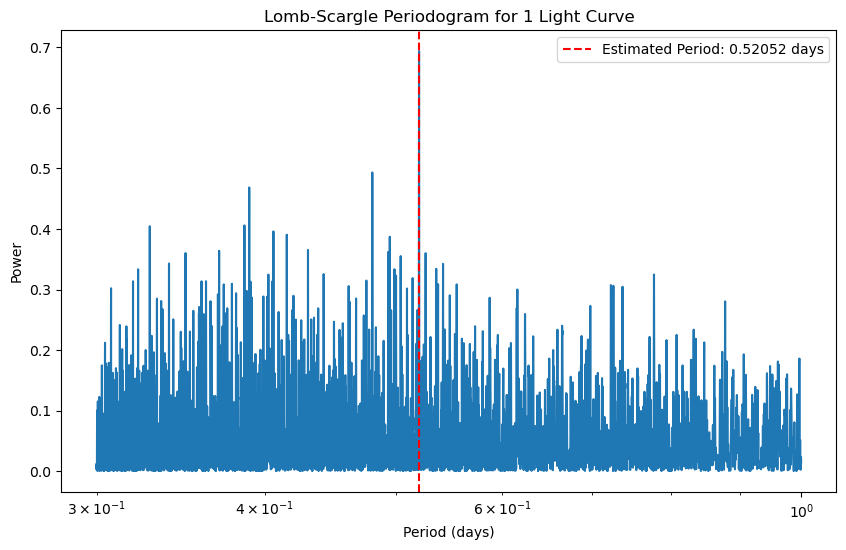

Estimated Period: 0.520523521474987 days
Estimated Mean G-band Magnitude: 15.870377539271471


In [5]:
time = np.array([row['time'] for row in specific_source_data])
mag = np.array([row['mag'] for row in specific_source_data])
# Converting magnitude to relative flux
flux = 10**(-0.4 * (mag - np.median(mag)))

# Lomb-Scargle Periodogram to estimate the period
ls = LombScargle(time, flux)
frequency, power = ls.autopower(minimum_frequency =1, maximum_frequency = (1/0.3))
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

# Plotting the periodogram
plt.figure(figsize=(10, 6))
plt.plot(1/frequency, power)
plt.axvline(x=best_period, color='r', linestyle='--', label=f'Estimated Period: {best_period:.5f} days')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.legend()
plt.title('Lomb-Scargle Periodogram for 1 Light Curve')
plt.xscale('log')
plt.savefig('1Q1_1.png')
plt.show()

# Computing the mean magnitude using flux
mean_flux = np.mean(flux)
# Converting mean flux back to magnitude
mean_mag = -2.5 * np.log10(mean_flux) + np.median(mag)  

print(f"Estimated Period: {best_period} days")
print(f"Estimated Mean G-band Magnitude: {mean_mag}")

## Period Comparison

In [6]:
query2 = """
SELECT TOP 100  
    source_id, 
    pf, 
    int_average_g, 
    num_clean_epochs_g
FROM 
    gaiadr3.vari_rrlyrae
WHERE 
    pf IS NOT NULL AND num_clean_epochs_g > 40
"""

job2 = Gaia.launch_job_async(query2)
results2 = job2.get_results()
print(results2[:100])
print(data_table)

INFO: Query finished. [astroquery.utils.tap.core]
     source_id               pf         int_average_g num_clean_epochs_g
                             d               mag                        
------------------- ------------------- ------------- ------------------
 245002531050576896  0.5205123049162365     15.929145                 45
 245504251951140864  0.5071152853230051      18.00016                 62
 245823861938360064 0.47876357277336673     19.339872                 59
 246756973652292992  0.4893027405323637     12.362016                 55
 359112665277840512  0.5017802473708718    15.8938055                 51
 414003442535159936   0.474867501878603     18.356619                 82
 414081061185873792  0.5889203707366553     18.591648                 82
 414152842984521856 0.36438054616789506     20.067835                 69
 414254032403091072  0.4181043701719148     16.543129                 62
 415000566440590976   0.617382983500351     14.803384                 54
 

## Series Representation for a Star

In [9]:
retrieval_type = 'EPOCH_PHOTOMETRY'          
data_structure = 'COMBINED'     
data_release   = 'Gaia DR3'

# Collecting ids=[5817567360327589632]

datalink2  = Gaia.load_data(ids=[5817567360327589632], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys2  = [inp for inp in datalink2.keys()]


dl_key2  = 'EPOCH_PHOTOMETRY-Gaia DR3 5817567360327589632.xml'     
product2  = datalink2[dl_key2][0]
product_tb1_5  = product2.to_table()# Exporting to Astropy Table object.
product_tb2 = [row for row in product_tb1_5 if row['band'] == 'G']

In [10]:
example_source_id2 = [5817567360327589632]  

# Filtering for the specific source_id
specific_source_data2 = [row for row in product_tb2 if row['source_id'] == example_source_id2]


times = np.array([row['time'] for row in specific_source_data2])
fluxes = np.array([row['mag'] for row in specific_source_data2])

# Computing the periodogram and finding the best period
frequency, power = LombScargle(times, fluxes).autopower(minimum_frequency =1, maximum_frequency = (1/0.3))
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

# Phasing the light curve
phase = (times % best_period)/ best_period

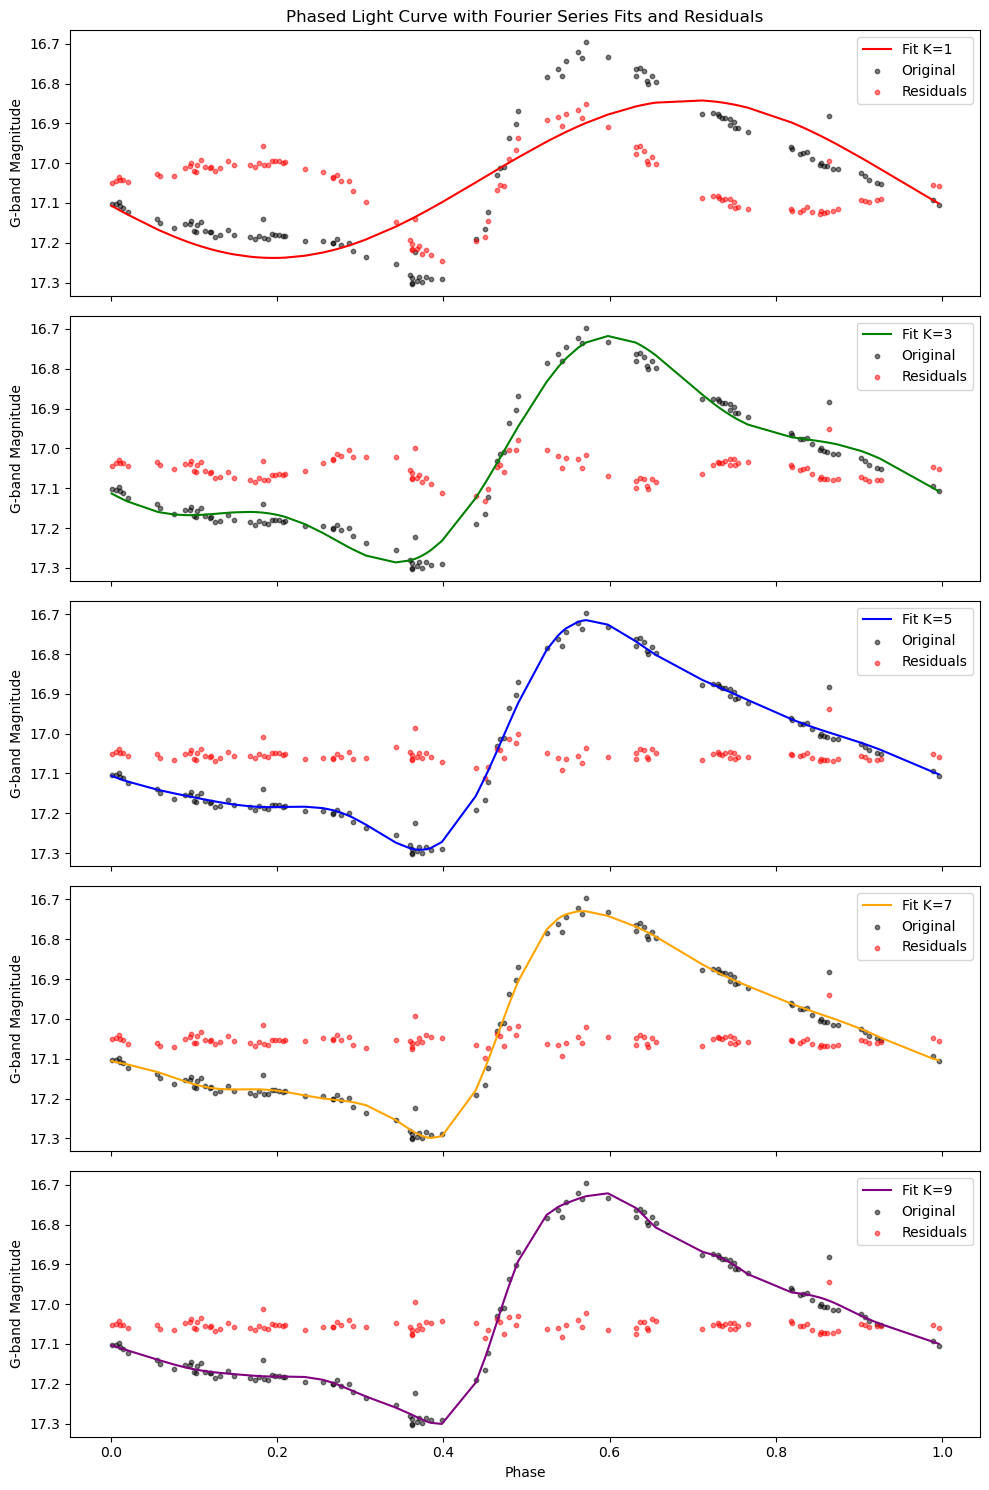

In [11]:
# Plotting for Fourier fits
fig, ax = plt.subplots(len([1, 3, 5, 7, 9]), 1, figsize=(10, 15), sharex=True)

colors = ['red', 'green', 'blue', 'orange', 'purple']  # Different color for each K

for i, K in enumerate([1, 3, 5, 7, 9]):

    X = np.column_stack([np.sin(2 * np.pi * k * phase) for k in range(1, K + 1)] +  
                        [np.cos(2 * np.pi * k * phase) for k in range(1, K + 1)])
    X = np.hstack([np.ones((len(phase), 1)), X])  

    coeffs = np.linalg.lstsq(X, fluxes, rcond=None)[0]
    fit_fluxes = X @ coeffs

    ax[i].plot(np.sort(phase), fit_fluxes[np.argsort(phase)], label=f'Fit K={K}', color=colors[i])
    ax[i].scatter(phase, fluxes, color='k', s=10, alpha=0.5, label='Original')  # Original data
    ax[i].set_ylabel('G-band Magnitude')
    ax[i].invert_yaxis()  # Magnitude plots are traditionally inverted

    # Calculation and plotting residuals on the same subplot
    residuals = fluxes - fit_fluxes
    ax[i].scatter(phase, residuals + np.mean(fit_fluxes), color='red', s=10, alpha=0.5, label='Residuals')

    ax[i].legend()

ax[-1].set_xlabel('Phase')
ax[0].legend()
ax[0].set_title('Phased Light Curve with Fourier Series Fits and Residuals')
plt.tight_layout()
plt.show()


### Finding Optimal Number of Terms

In [12]:
from sklearn.model_selection import train_test_split


# Splitting the data: 80% for training, 20% for validation
times_train, times_val, fluxes_train, fluxes_val = train_test_split(times, fluxes, test_size=0.2)

MSE Train Data Set
K=1: χ²/N_data(train): 0.00030844704191367354, χ²/N_data(val): 0.0017500576377713693
K=2: χ²/N_data(train): 0.00030966141404604715, χ²/N_data(val): 0.002020878043128776
K=3: χ²/N_data(train): 0.00031204027386028864, χ²/N_data(val): 0.0023519453052468216
K=4: χ²/N_data(train): 0.0003165585904739784, χ²/N_data(val): 0.0027881979358014993
K=5: χ²/N_data(train): 0.0003199411556840858, χ²/N_data(val): 0.0037712388532339255
K=6: χ²/N_data(train): 0.0003282592639580081, χ²/N_data(val): 0.004550296731052161
K=7: χ²/N_data(train): 0.0003354673026967185, χ²/N_data(val): 0.005331239228045281
K=8: χ²/N_data(train): 0.0003232548332450435, χ²/N_data(val): 0.007035101623750892
K=9: χ²/N_data(train): 0.00031437786796185074, χ²/N_data(val): 0.010898644202758287
K=10: χ²/N_data(train): 0.0003059198421237377, χ²/N_data(val): 0.019940060247872208
K=11: χ²/N_data(train): 0.00031069519565060454, χ²/N_data(val): inf
K=12: χ²/N_data(train): 0.0003191002618679172, χ²/N_data(val): -0.02160386

/tmp/ipykernel_10967/3660937875.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  chi_square_per_dof_val = mse_val / (len(fluxes_val) - (2*K + 1))


K=22: χ²/N_data(train): 0.00036377697751211363, χ²/N_data(val): -0.012088616113341511
K=23: χ²/N_data(train): 0.0003317019084935258, χ²/N_data(val): -0.12965834172293877
K=24: χ²/N_data(train): 0.0003482596028464872, χ²/N_data(val): -0.19890597778966107
K=25: χ²/N_data(train): 0.000354448814290805, χ²/N_data(val): -0.6842707930369459


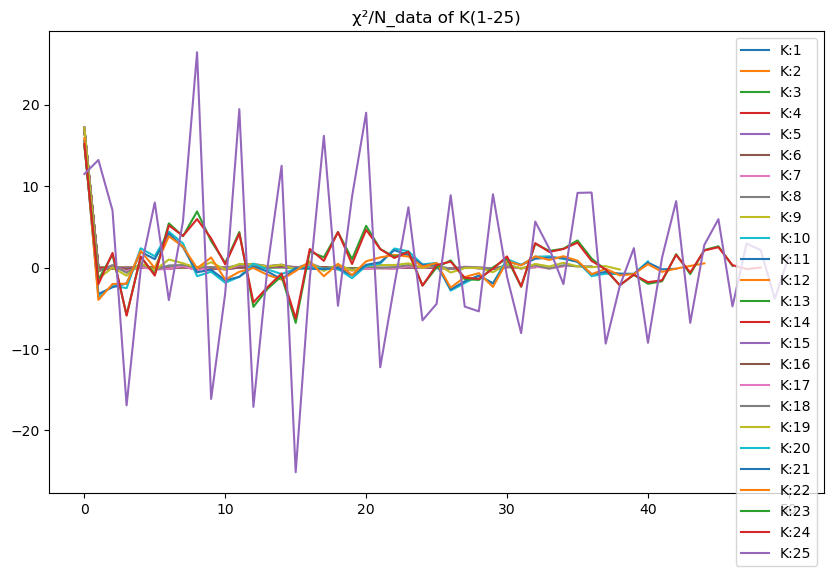

In [13]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error


# Known period P and angular frequency ω
P = .5  # Determined from Lomb-Scargle periodogram 
omega = 2 * np.pi / P

# Fourier series AS A FUNCTION NOW
def fourier_series(t, A0, *coeffs):
    K = len(coeffs) // 2
    result = A0
    for k in range(1, K + 1):
        a_k, b_k = coeffs[2*k - 2], coeffs[2*k - 1]
        result += a_k * np.sin(k * omega * t) + b_k * np.cos(k * omega * t)
    return result

# Fitting the Fourier series for a range of K values and calculate χ²/N_data
K_values = list(range(1, 26))
mse_values = []

print(f"MSE Train Data Set")

plt.figure(figsize=(10, 6))

chi_square_per_dof_train_list = []
chi_square_per_dof_val_list = []

for K in K_values:
    initial_guess = [np.mean(fluxes_train)] + [0] * (2 * K)
    params, params_covariance = curve_fit(fourier_series, times_train, fluxes_train, p0=initial_guess)
    
    # Prediction of fluxes using the fitted model for both training and validation sets
    fluxes_pred_train = fourier_series(times_train, *params)
    fluxes_pred_val = fourier_series(times_val, *params)

    # Calculation of χ²/N_data for training and validation sets
    mse_train = mean_squared_error(fluxes_train, fluxes_pred_train)
    mse_val = mean_squared_error(fluxes_val, fluxes_pred_val)
    
    # Assuming uniform variance, MSE as an approximation for χ²/N_data
    chi_square_per_dof_train = mse_train / (len(fluxes_train) - (2*K + 1))
    chi_square_per_dof_val = mse_val / (len(fluxes_val) - (2*K + 1))

    plt.plot(params, label =f"K:{K}")

    chi_square_per_dof_train_list.append(chi_square_per_dof_train)
    chi_square_per_dof_val_list.append(chi_square_per_dof_val)

    print(f"K={K}: χ²/N_data(train): {chi_square_per_dof_train}, χ²/N_data(val): {chi_square_per_dof_val}")
plt.legend()
plt.title("χ²/N_data of K(1-25)")
plt.show()

## Finding Future Magnitude Prediction Using k = 10

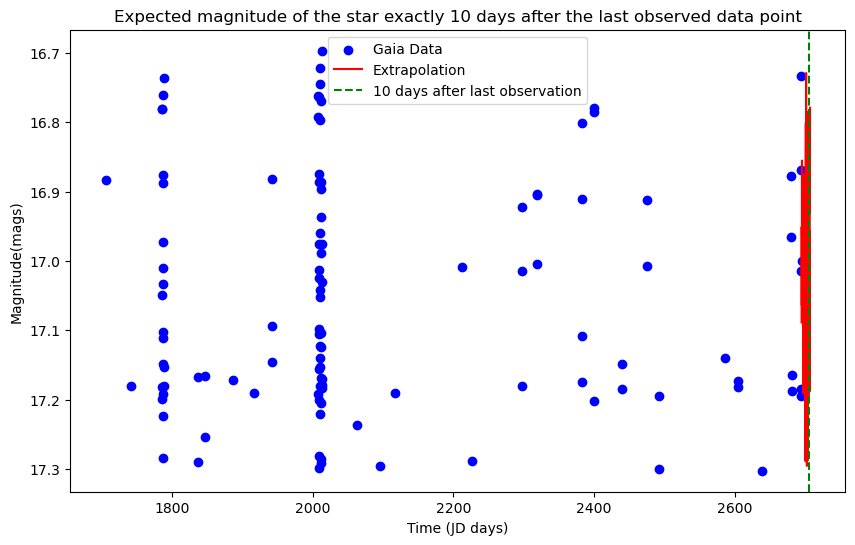

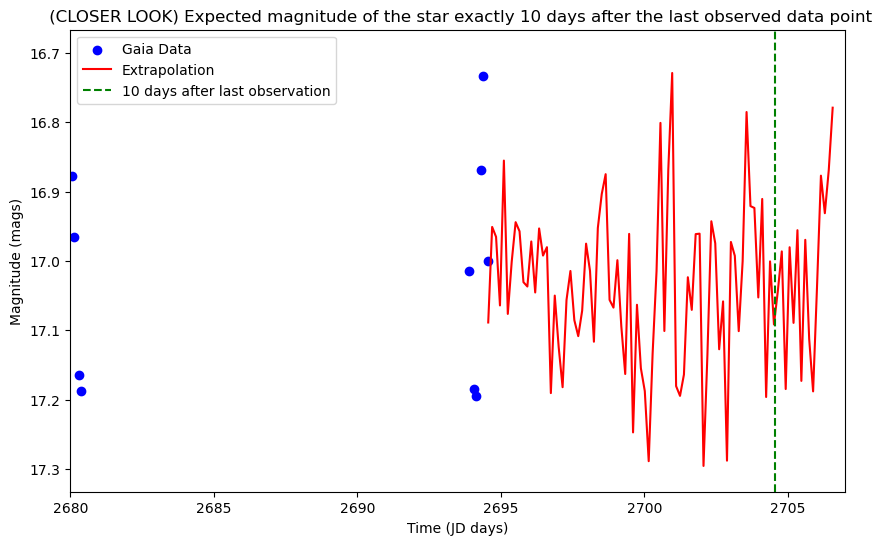

In [14]:
# BEST FOURIER SERIES K MODEL W/ K =10
def fourier_series(t, A0, *coeffs):
    K = 10  # Based on the chosen value from cross-validation
    omega = 2 * np.pi / .3  
    result = A0
    for k in range(1, K + 1):
        a_k, b_k = coeffs[2*k - 2], coeffs[2*k - 1]
        result += a_k * np.sin(k * omega * t) + b_k * np.cos(k * omega * t)
    return result

# The last observed time point
t_last = max(times_train)  

# Time points for prediction
t_pred = np.linspace(t_last, t_last + 12, 89)  # Next 12 days


# Update plotting section to use magnitudes
plt.figure(figsize=(10, 6))
plt.scatter(times, fluxes, color='blue', label='Gaia Data')  # Last few observed points
plt.plot(t_pred, fluxes_pred_train, color='red', label='Extrapolation')
plt.axvline(x=t_last + 10, color='green', linestyle='--', label='10 days after last observation')
plt.xlabel('Time (JD days)')
plt.ylabel('Magnitude(mags)')
plt.legend()
plt.title("Expected magnitude of the star exactly 10 days after the last observed data point")
plt.gca().invert_yaxis()  
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(times, fluxes, color='blue', label='Gaia Data')  
plt.plot(t_pred, fluxes_pred_train, color='red', label='Extrapolation')
plt.axvline(x=t_last + 10, color='green', linestyle='--', label='10 days after last observation')
plt.xlabel('Time (JD days)')
plt.ylabel('Magnitude (mags)')
plt.legend()
plt.xlim(2680,2707)
plt.title(" (CLOSER LOOK) Expected magnitude of the star exactly 10 days after the last observed data point")
plt.gca().invert_yaxis()  
plt.show()


## Determining Mean Magnitude Estimation with Fourier Model

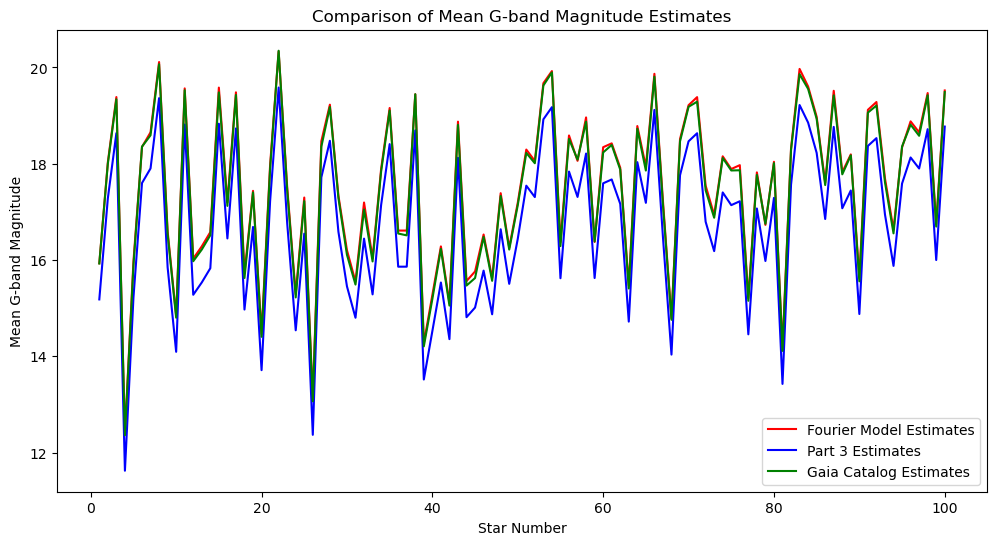

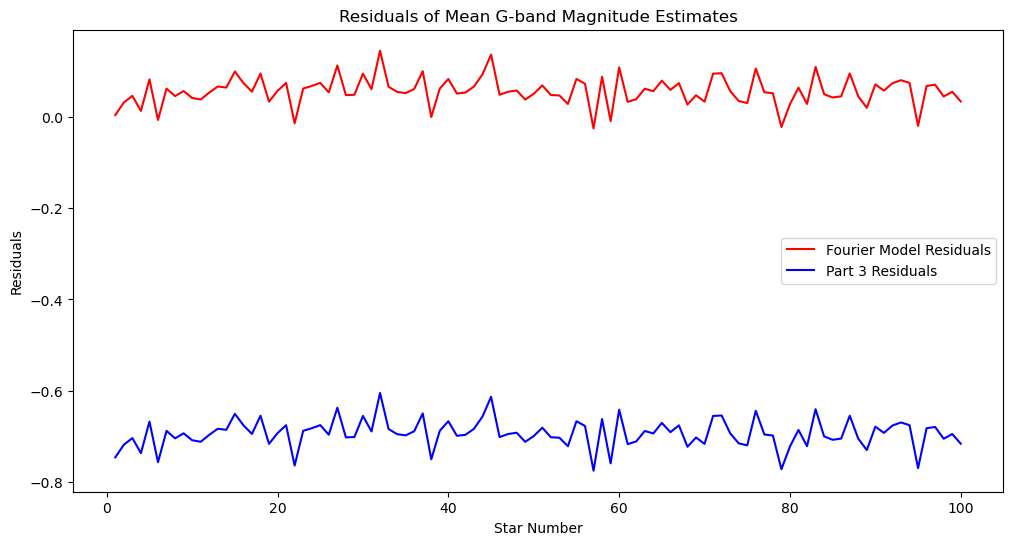

In [15]:
# Calculating mean magnitude using the Fourier model
mean_magnitudes_fourier = []


for source_id in source_ids[:100]:  # Limiting to first 100 for demonstration

    current_data = g_band_rows[g_band_rows['source_id'] == source_id]

    time = current_data['time'].data
    flux = current_data['flux']
    flux_error = current_data['flux_error']

    
    # Estimating the period using Lomb-Scargle periodogram
    ls = LombScargle(time, flux)
    frequency, power = ls.autopower(minimum_frequency =1, maximum_frequency = (1/0.3))

    
    best_frequency = frequency[np.argmax(power)]
    P = 1 / best_frequency

    K = 10  # BEST number of harmonics

    # Construct the design matrix for the Fourier series
    X = np.column_stack([np.sin(2 * np.pi * k * time / P) for k in range(1, K + 1)] +
                    [np.cos(2 * np.pi * k * time/ P) for k in range(1, K + 1)])
    X = np.hstack([np.ones((len(time), 1)), X])  

    # Solving for the coefficients using least squares
    coeffs = np.linalg.lstsq(X, flux, rcond=None)[0]

    # Calculating the fitted fluxes
    fit_fluxes = X @ coeffs

    # Calculating the mean flux from the fitted model and convert to magnitude
    mean_flux = np.mean(fit_fluxes)
    mean_magnitude = -2.5 * np.log10(mean_flux) + 25.75  

    mean_magnitudes_fourier.append(mean_magnitude)
    


gaia_mean_magnitudes = results2['int_average_g']
mean_mag = data_table['mean_mag']

# Plotting the estimates
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), mean_magnitudes_fourier, 'r-', label='Fourier Model Estimates')
plt.plot(range(1, 101), mean_mag, 'b-', label='Part 3 Estimates')
plt.plot(range(1, 101), gaia_mean_magnitudes, 'g-', label='Gaia Catalog Estimates')
plt.xlabel('Star Number')
plt.ylabel('Mean G-band Magnitude')
plt.title('Comparison of Mean G-band Magnitude Estimates')
plt.legend()

# Plotting the residuals
plt.figure(figsize=(12, 6))
plt.plot(range(1, 101), np.array(mean_magnitudes_fourier) - np.array(gaia_mean_magnitudes), 'r-', label='Fourier Model Residuals')
plt.plot(range(1, 101), np.array(mean_mag) - np.array(gaia_mean_magnitudes), 'b-', label='Part 3 Residuals')
plt.xlabel('Star Number')
plt.ylabel('Residuals')
plt.title('Residuals of Mean G-band Magnitude Estimates')
plt.legend()

plt.show()



## Comparing RRab and RRc Light Curve Shapes

INFO: Query finished. [astroquery.utils.tap.core]


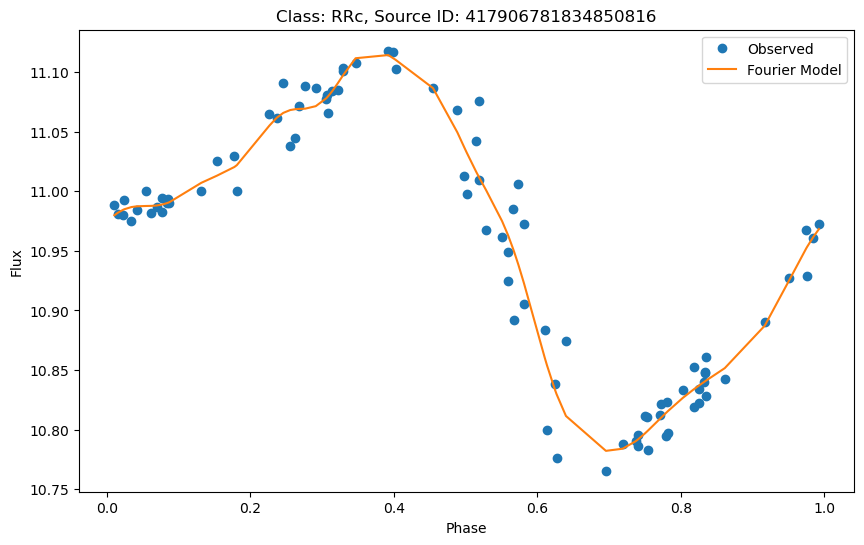

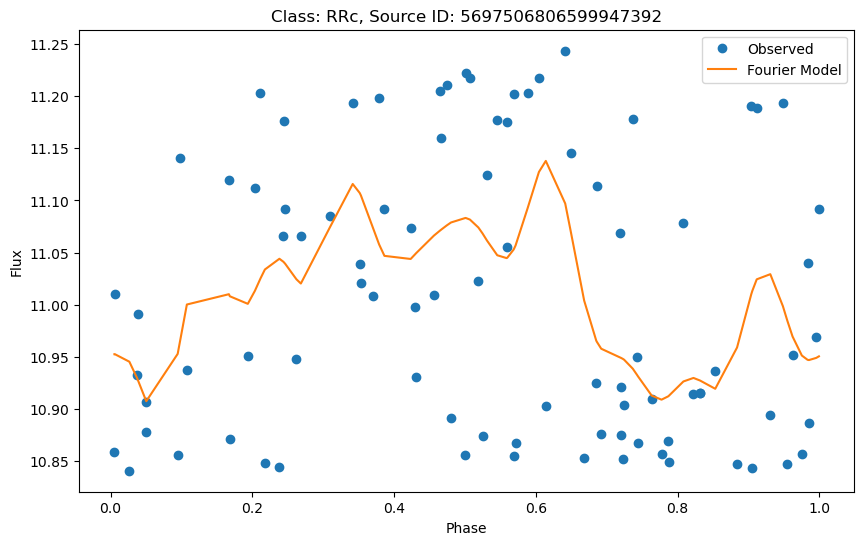

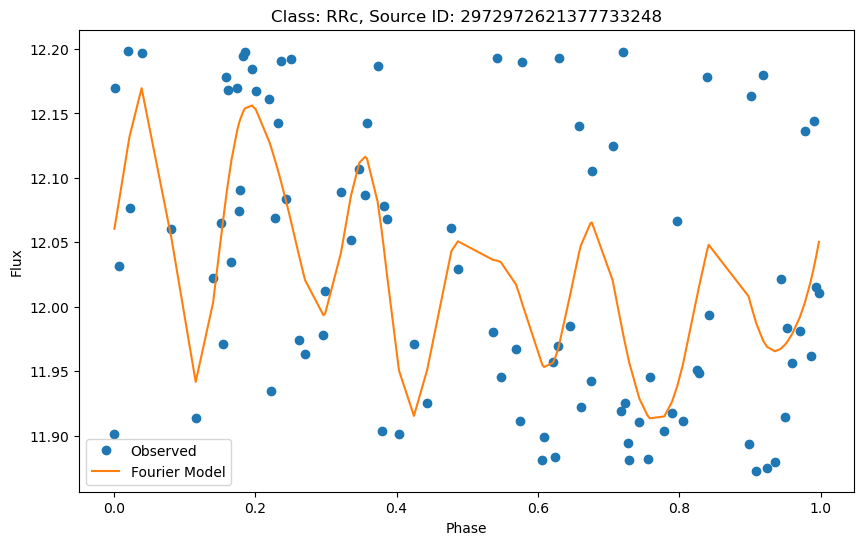

INFO: Query finished. [astroquery.utils.tap.core]


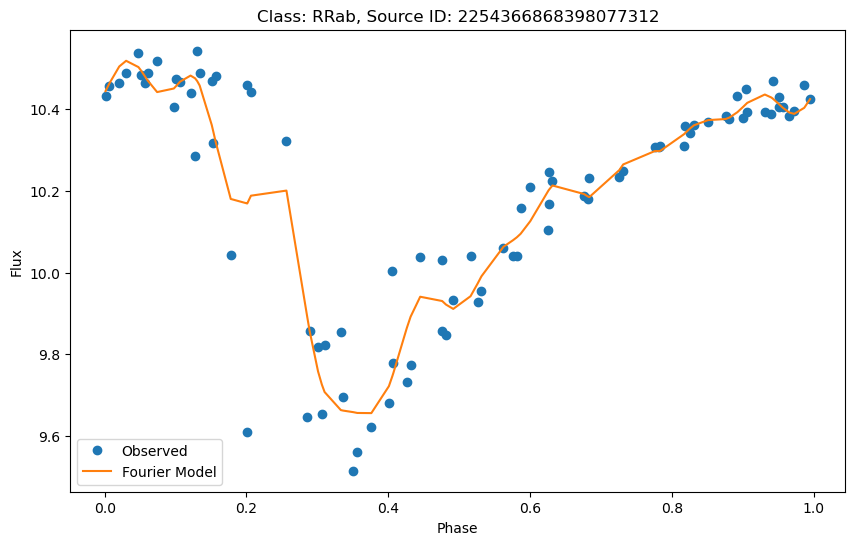

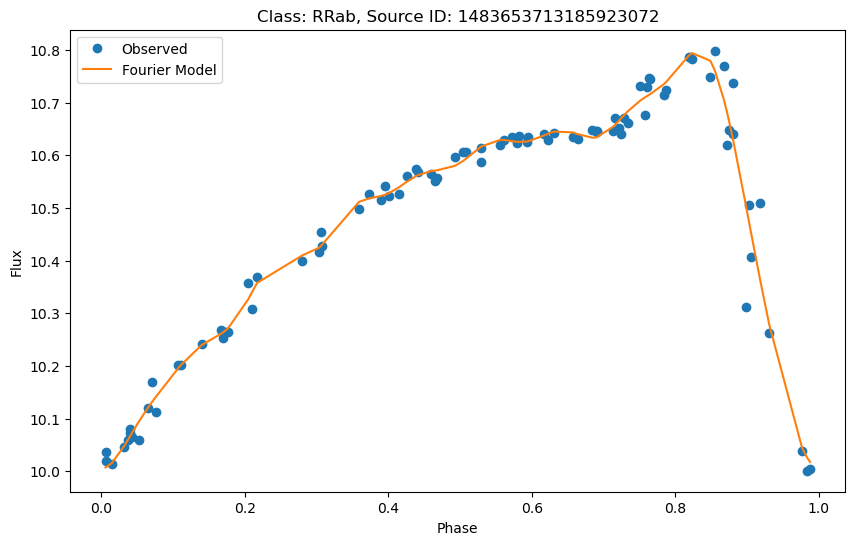

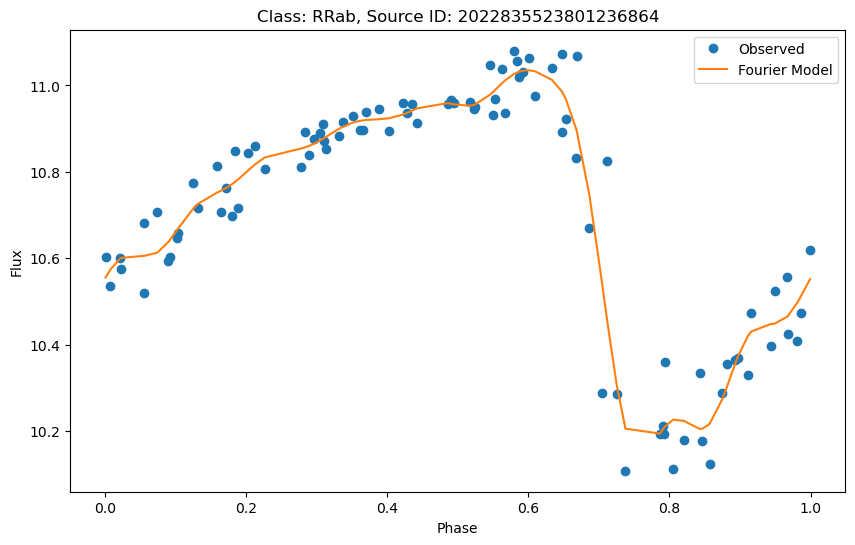

In [16]:
# Function to plot phased light curves and Fourier models
def plot_phased_light_curve(time, flux, period, coeffs, K, classification, source_id):
    phase = (time % period) / period
    sorted_indices = np.argsort(phase)
    sorted_phase = phase[sorted_indices]
    sorted_flux = flux[sorted_indices]
    
    # Constructing the Fourier series model
    model_flux = np.ones_like(sorted_phase) * coeffs[0]
    for k in range(1, K + 1):
        model_flux += coeffs[k] * np.sin(2 * np.pi * k * sorted_phase) + coeffs[k + K] * np.cos(2 * np.pi * k * sorted_phase)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_phase, sorted_flux, 'o', label='Observed')
    plt.plot(sorted_phase, model_flux, '-', label='Fourier Model')
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    plt.title(f'Class: {classification}, Source ID: {source_id}')
    plt.legend()
    plt.show()

# Query for RRc and RRab stars
for classification in ['RRc', 'RRab']:
    query = f"""
    SELECT TOP 3 
        source_id, 
        pf, 
        int_average_g
    FROM 
        gaiadr3.vari_rrlyrae
    WHERE 
        best_classification = '{classification}'
        AND int_average_g < 15
        AND num_clean_epochs_g > 80
    ORDER BY 
        int_average_g ASC
    """
    job = Gaia.launch_job_async(query)
    results = job.get_results()
    
    for row in results:

        
        source_id = row['source_id']
        datalink = Gaia.load_data(ids=[source_id], data_structure='COMBINED', retrieval_type='EPOCH_PHOTOMETRY')


        light_curve_key = list(datalink.keys())[0]  
        light_curve1 = datalink[light_curve_key][0].to_table()
        light_curve = light_curve1[light_curve1['band'] == 'G']

        time = light_curve['time'].data
        flux = light_curve['mag'].data
        ls = LombScargle(time, flux)
        frequency, power = ls.autopower(minimum_frequency =1, maximum_frequency = (1/0.3))

    
        best_frequency = frequency[np.argmax(power)]
        period = 1 / best_frequency
        
        
        # Fitting Fourier series to the light curve
        K = 10  
        X = np.column_stack([np.sin(2 * np.pi * k * time / period) for k in range(1, K + 1)] +
                            [np.cos(2 * np.pi * k * time / period) for k in range(1, K + 1)])
        X = np.hstack([np.ones((len(time), 1)), X])
        coeffs = np.linalg.lstsq(X, flux, rcond=None)[0]
        
        # Plotting the phased light curve and Fourier model
        plot_phased_light_curve(time, flux, period, coeffs, K, classification, source_id)


## Establishing RR Lyrae Period-Luminosity Relation

In [17]:
# ADQL query to select RR Lyrae stars with specific criteria
query = """
SELECT 
    source_id, 
    ra, 
    dec, 
    parallax, 
    phot_g_mean_mag,
    phot_bp_mean_mag,
    phot_rp_mean_mag,
    b,
    l,
    parallax_error,
    parallax_over_error
FROM 
    gaiadr3.gaia_source 
JOIN 
    gaiadr3.vari_rrlyrae 
USING (source_id)
WHERE 
    parallax_over_error > 5 
    AND abs(b) > 30 
    AND parallax > 0.25
    AND best_classification = 'RRab'
"""

job = Gaia.launch_job_async(query)
results1 = job.get_results()
results1

INFO: Query finished. [astroquery.utils.tap.core]


<Table length=665>
     source_id              ra         ... parallax_error parallax_over_error
                           deg         ...      mas                          
       int64             float64       ...    float32           float32      
------------------- ------------------ ... -------------- -------------------
5082275006547809536 55.908656887737756 ...    0.016528321           16.220354
5083946363004134144  57.46167951706597 ...    0.017433707           34.110825
5094203642556959744  60.80074303875493 ...    0.020860914            24.04988
5094426804761045248  60.04487036910923 ...    0.015646426           26.117859
5098240155900394112  51.16015378180931 ...    0.017754834           20.336185
4658048266412380288   82.3241822609254 ...     0.28667924            5.390358
4654699433004977920  73.25966067452313 ...      1.2755656           6.3277464
 580348453620559360 136.20240348333073 ...    0.049243838           10.526195
 584371601026374272 133.72290623274645 ...    0.017206505           29.193705
                ...                ... ...            ...                 ...
 648476397396238976 145.86990336610856 ...    0.020715533           24.072163
3717352885416905984  200.5881071358682 ...    0.019772055           23.905779
3719179552187828992 200.91800299036544 ...     0.01768264           15.516169
3727833391597367424 209.69308079142908 ...    0.023121158           33.401142
3731723090075245696 200.04819969340105 ...    0.022247566           25.068665
3737667393532367616 197.18468166756443 ...     0.02422253           12.897187
6255453672871215616 232.82829156406103 ...    0.019708479           14.865601
6257531784202384000  227.4627859037128 ...     0.01742736           16.892292
1183706283996839680  225.3872935033853 ...    0.015389868           21.371807
1185942999884896640 219.59070157774215 ...    0.018918512           15.233353

## Distance Estimates with Galactic Structure Prior

Bailer-Jones Catalog https://arxiv.org/abs/2012.05220

In [18]:
# ADQL query to select geometric distances for the RR Lyrae stars

query = """
SELECT 
    gaia.source_id,
    rrlyrae.best_classification, 
    gaia.ra, 
    gaia.dec, 
    gaia.parallax, 
    gaia.phot_g_mean_mag,
    gaia.phot_bp_mean_mag,
    gaia.phot_rp_mean_mag,
    dist.r_med_geo AS distance_median,
    dist.r_lo_geo AS distance_lower,
    dist.r_hi_geo AS distance_upper
FROM 
    gaiadr3.gaia_source AS gaia
JOIN 
    gaiadr3.vari_rrlyrae AS rrlyrae 
    ON gaia.source_id = rrlyrae.source_id
JOIN 
    external.gaiaedr3_distance AS dist 
    ON gaia.source_id = dist.source_id
WHERE 
    rrlyrae.best_classification = 'RRab'
    AND gaia.parallax_over_error > 5 
    AND abs(gaia.b) > 30 
    AND gaia.parallax > 0.25
"""

job = Gaia.launch_job_async(query)
results2 = job.get_results()

results2

INFO: Query finished. [astroquery.utils.tap.core]


<Table length=665>
     source_id      best_classification ... distance_lower distance_upper
                                        ...       pc             pc      
       int64               object       ...    float32        float32    
------------------- ------------------- ... -------------- --------------
5082275006547809536                RRab ...      3081.9224      3426.7776
5083946363004134144                RRab ...      1558.1212      1652.5009
5094203642556959744                RRab ...      1809.5858      1978.6187
5094426804761045248                RRab ...      2213.6853      2390.4333
5098240155900394112                RRab ...      2500.5015       2714.123
4658048266412380288                RRab ...        576.464      817.82166
4654699433004977920                RRab ...       116.3465      178.88231
 580348453620559360                RRab ...      1656.3534      1955.4971
 584371601026374272                RRab ...      1837.6722      1942.4014
                ...                 ... ...            ...            ...
 648476397396238976                RRab ...      1789.4633      1938.1553
3717352885416905984                RRab ...      1925.4808       2067.964
3719179552187828992                RRab ...       2956.674      3275.4878
3727833391597367424                RRab ...        1200.33      1263.0288
3731723090075245696                RRab ...      1596.8693      1700.4858
3737667393532367616                RRab ...       2655.234      3014.0408
6255453672871215616                RRab ...       2795.866      3155.7043
6257531784202384000                RRab ...      2811.0996      3075.7012
1183706283996839680                RRab ...       2676.745      2921.4912
1185942999884896640                RRab ...      2917.7317       3252.363

## Finding Galactic Distribution of Targets

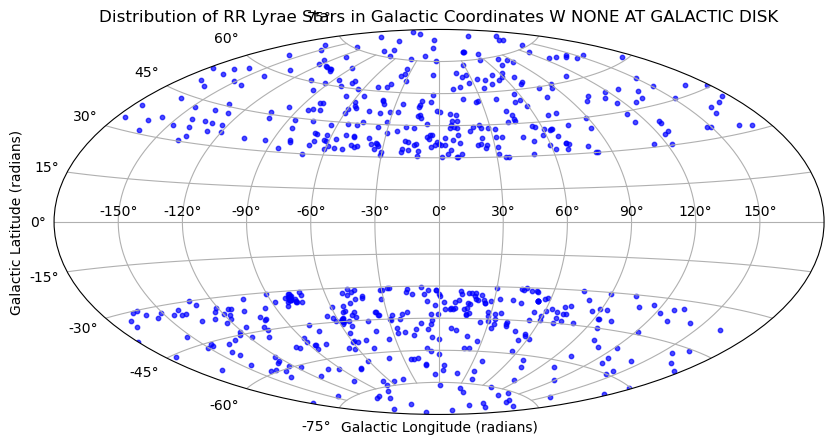

In [19]:
# Extracting Galactic longitude (l) and latitude (b) from the query results
l = results1['l']
b = results1['b']

l = l % 360  
l[l > 180] -= 360 

# Convering to radians for plotting
l_rad = np.radians(l)
b_rad = np.radians(b)

# Plotting the distribution using an Aitoff projection
plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='aitoff')
ax.scatter(l_rad, b_rad, s=10, alpha=0.7, color='blue')
ax.set_title('Distribution of RR Lyrae Stars in Galactic Coordinates W NONE AT GALACTIC DISK')
ax.set_xlabel('Galactic Longitude (radians)')
ax.set_ylabel('Galactic Latitude (radians)')
ax.grid(True)

plt.show()


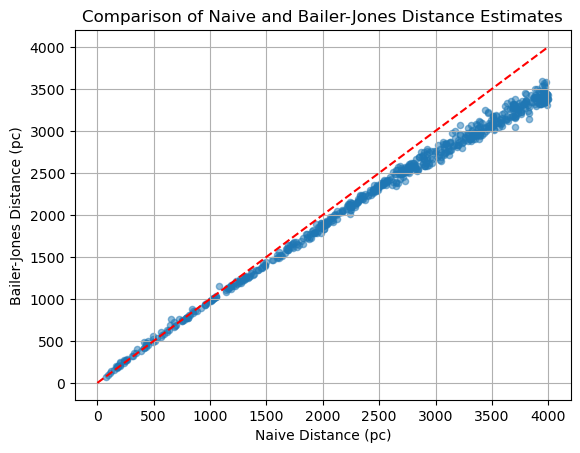

In [20]:
# Calculating naive distances
naive_distances = 1.0 / results2['parallax'] * 1000  # Convert from mas to pc
# Extracting Bailer-Jones distances
bj_distances = results2['distance_median']
# Creating a DF for easier plotting
comparison_df = pd.DataFrame({
    'Naive Distance (pc)': naive_distances,
    'Bailer-Jones Distance (pc)': bj_distances
})
# Plotting comparison
comparison_df.plot(kind='scatter', x='Naive Distance (pc)', y='Bailer-Jones Distance (pc)', alpha=0.5)
plt.plot([0, max(comparison_df['Naive Distance (pc)'])], [0, max(comparison_df['Naive Distance (pc)'])], 'r--')  
plt.xlabel('Naive Distance (pc)')
plt.ylabel('Bailer-Jones Distance (pc)')
plt.title('Comparison of Naive and Bailer-Jones Distance Estimates')
plt.grid(True)
plt.show()

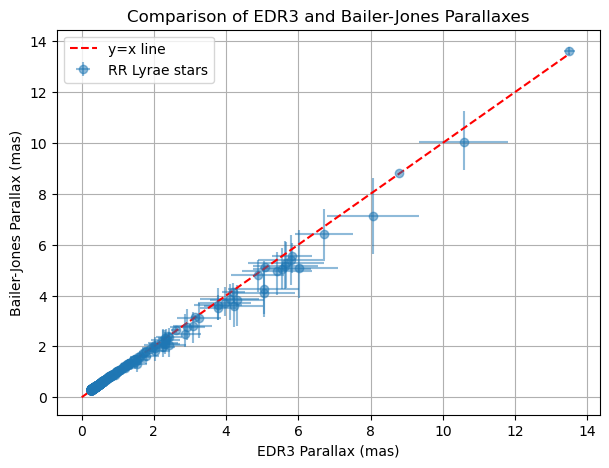

Average difference between EDR3 and Bailer-Jones parallaxes: -0.01 mas


In [21]:
# EDR3 parallaxes and uncertainties
edr3_parallaxes = results2['parallax']
edr3_parallax_errors = results1['parallax_error']

# Bailer-Jones parallaxes  uncertainties
bj_parallaxes = 1.0 / results2['distance_median'] * 1000  # Convert from pc to mas
bj_parallax_lower_errors = 1.0 / results2['distance_lower'] * 1000 - bj_parallaxes
bj_parallax_upper_errors = bj_parallaxes - 1.0 / results2['distance_upper'] * 1000

# Plotting
plt.figure(figsize=(7, 5))
plt.errorbar(edr3_parallaxes, bj_parallaxes, xerr=edr3_parallax_errors, yerr=[bj_parallax_lower_errors, bj_parallax_upper_errors], fmt='o', alpha=0.5, label='RR Lyrae stars')
plt.plot([0, max(edr3_parallaxes)], [0, max(edr3_parallaxes)], 'r--', label='y=x line')
plt.xlabel('EDR3 Parallax (mas)')
plt.ylabel('Bailer-Jones Parallax (mas)')
plt.title('Comparison of EDR3 and Bailer-Jones Parallaxes')
plt.legend()
plt.grid(True)
plt.show()

# Calculating the avg difference between EDR3 and Bailer-Jones parallaxes
average_difference = np.mean(edr3_parallaxes - bj_parallaxes)
print(f'Average difference between EDR3 and Bailer-Jones parallaxes: {average_difference:.2f} mas')


## Creating Period vs. Absolute Magnitude Plot

INFO: Query finished. [astroquery.utils.tap.core]


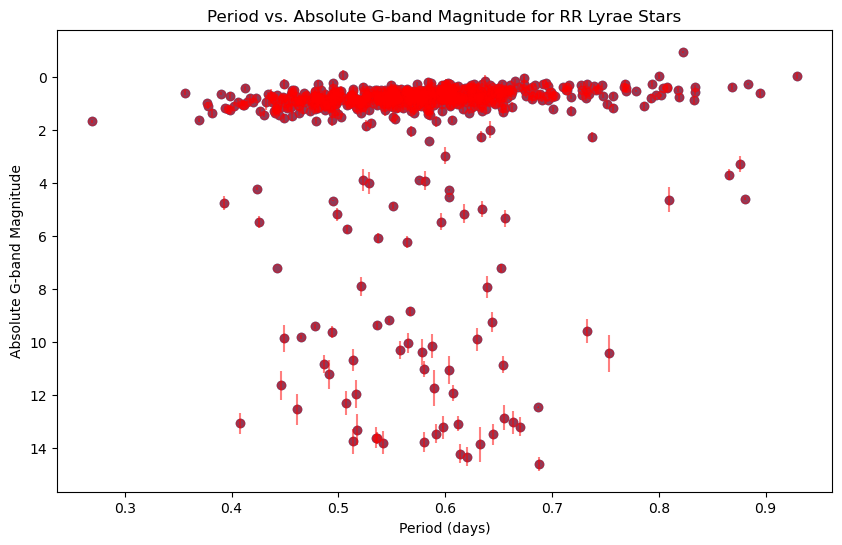

In [22]:
# ADQL query with geometric distances for the RR Lyrae stars with period info
query = """
SELECT 
    gaia.source_id, 
    gaia.ra, 
    gaia.dec,
    rrlyrae.best_classification, 
    gaia.parallax, 
    gaia.phot_g_mean_mag,
    gaia.phot_bp_mean_mag,
    gaia.phot_rp_mean_mag,
    gaia.astrometric_chi2_al,
    gaia.astrometric_n_good_obs_al,
    gaia.phot_bp_rp_excess_factor,
    dist.r_med_geo AS distance_median,
    dist.r_lo_geo AS distance_lower,
    dist.r_hi_geo AS distance_upper,
    rrlyrae.pf AS period,
    rrlyrae.pf_error AS period_error,
    rrlyrae.int_average_g
FROM 
    gaiadr3.gaia_source AS gaia
JOIN 
    gaiadr3.vari_rrlyrae AS rrlyrae 
    ON gaia.source_id = rrlyrae.source_id
JOIN 
    external.gaiaedr3_distance AS dist 
    ON gaia.source_id = dist.source_id
WHERE 
    rrlyrae.best_classification = 'RRab'
    AND gaia.parallax_over_error > 5 
    AND abs(gaia.b) > 30 
    AND gaia.parallax > 0.25
"""

job = Gaia.launch_job_async(query)
results3 = job.get_results()

results3



# Calculating absolute G-band magnitude using Bailer-Jones distances
distance_median = results3['distance_median']
distance_error = (results3['distance_upper'] - results3['distance_lower']) / 2
abs_mag_g = results3['int_average_g'] - 5 * np.log10(distance_median) + 5

# Plotting period vs. absolute G-band magnitude
plt.figure(figsize=(10, 6))
plt.scatter(results3['period'], abs_mag_g)
plt.errorbar(results3['period'], abs_mag_g, xerr=results3['period_error'], yerr=5 / np.log(10) * distance_error / distance_median, fmt='o', alpha=0.5, color = 'red')
plt.gca().invert_yaxis() 
plt.xlabel('Period (days)')
plt.ylabel('Absolute G-band Magnitude')
plt.title('Period vs. Absolute G-band Magnitude for RR Lyrae Stars')
plt.show()


## Scatter Reduction with Quality Cuts

Quality Cuts: https://arxiv.org/abs/1804.09366

INFO: Query finished. [astroquery.utils.tap.core]


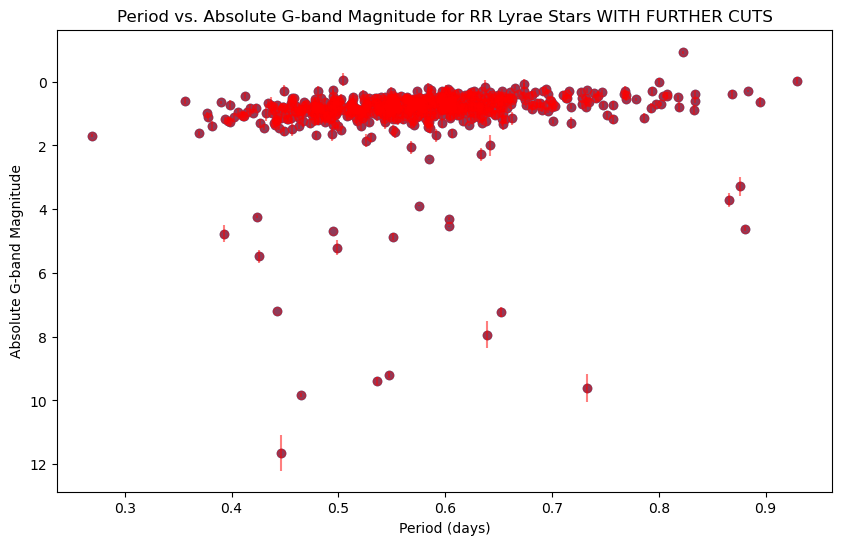

In [23]:
# ADQL query with geometric distances for the RR Lyrae stars with period info AND Additional Cuts
query = """
SELECT 
    gaia.source_id, 
    gaia.ra,
    rrlyrae.best_classification,
    gaia.dec,
    gaia.parallax, 
    gaia.phot_g_mean_mag,
    gaia.phot_bp_mean_mag,
    gaia.phot_rp_mean_mag,
    gaia.astrometric_chi2_al,
    gaia.astrometric_n_good_obs_al,
    gaia.phot_bp_rp_excess_factor,
    dist.r_med_geo AS distance_median,
    dist.r_lo_geo AS distance_lower,
    dist.r_hi_geo AS distance_upper,
    rrlyrae.pf AS period,
    rrlyrae.pf_error AS period_error,
    rrlyrae.int_average_g
FROM 
    gaiadr3.gaia_source AS gaia
JOIN 
    gaiadr3.vari_rrlyrae AS rrlyrae 
    ON gaia.source_id = rrlyrae.source_id
JOIN 
    external.gaiaedr3_distance AS dist 
    ON gaia.source_id = dist.source_id
WHERE 
    rrlyrae.best_classification = 'RRab'
    AND gaia.parallax_over_error > 5 
    AND abs(gaia.b) > 30 
    AND gaia.parallax > 0.25
    AND (1.0 + 0.015 * POWER(gaia.phot_bp_mean_mag - gaia.phot_rp_mean_mag, 2)) < gaia.phot_bp_rp_excess_factor
    AND gaia.phot_bp_rp_excess_factor < (1.3 + 0.06 * POWER(gaia.phot_bp_mean_mag - gaia.phot_rp_mean_mag, 2))
    AND POWER(gaia.astrometric_chi2_al / gaia.astrometric_n_good_obs_al, 0.5) < 1.2 * GREATEST(1, EXP(-0.2 * (rrlyrae.int_average_g - 19.5)))
"""


job = Gaia.launch_job_async(query)
results3 = job.get_results()

results3

# Calculating absolute G-band magnitude using Bailer-Jones distances
distance_median = results3['distance_median']
distance_error = (results3['distance_upper'] - results3['distance_lower']) / 2
abs_mag_g = results3['int_average_g'] - 5 * np.log10(distance_median) + 5
results3['abs_mag_g'] =  abs_mag_g
# Plotting period vs. absolute G-band magnitude
plt.figure(figsize=(10, 6))
plt.scatter(results3['period'], abs_mag_g)
plt.errorbar(results3['period'], abs_mag_g, xerr=results3['period_error'], yerr=5 / np.log(10) * distance_error / distance_median, fmt='o', alpha=0.5, color = 'red')
plt.gca().invert_yaxis() 
plt.xlabel('Period (days)')
plt.ylabel('Absolute G-band Magnitude')
plt.title('Period vs. Absolute G-band Magnitude for RR Lyrae Stars WITH FURTHER CUTS')
plt.show()


## Applying More Outlier Removal

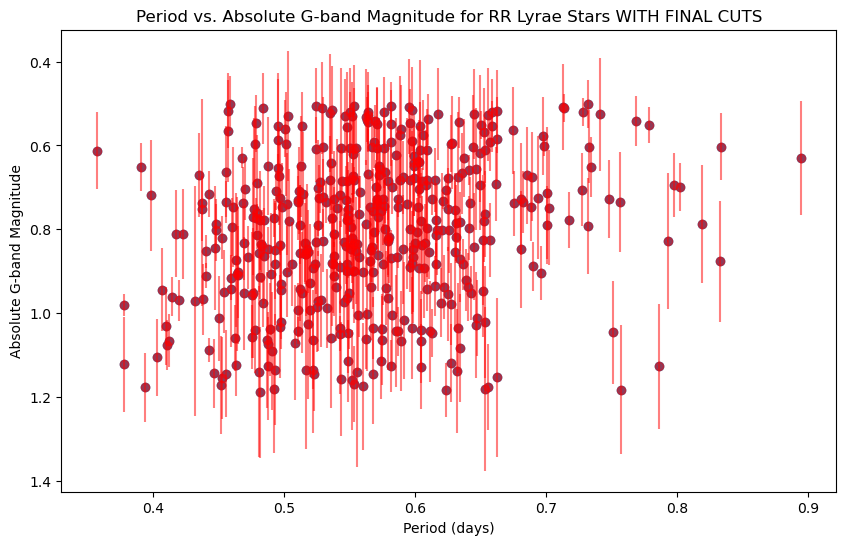

<Table length=441>
     source_id              ra         ... abs_mag_g  abs_mag_error
                           deg         ...                         
       int64             float64       ...  float32      float32   
------------------- ------------------ ... ---------- -------------
5082275006547809536 55.908656887737756 ... 0.90214825     0.1151392
5083946363004134144  57.46167951706597 ...  1.0220299    0.06375353
5094203642556959744  60.80074303875493 ...  0.6100693    0.09731757
5094426804761045248  60.04487036910923 ... 0.63723373     0.0835178
 584371601026374272 133.72290623274645 ... 0.88380814   0.060341623
 586254622063844736 142.60890413338174 ...   0.638669    0.09837258
3844396540563624832 142.28065991626687 ...  0.7824669    0.07036452
1154484945718096000 223.67339149871557 ...  1.1539621    0.18880163
1154932172072449280 224.62096968890128 ...  1.1893921     0.1562309
                ...                ... ...        ...           ...
3686046284680810752 195.98082909028878 ... 0.66997814    0.13628566
 630421935431871232 151.93101079342685 ... 0.82015705   0.051970262
 632467228922479104 141.32105353151945 ... 0.73885727    0.20460102
 648476397396238976 145.86990336610856 ...  0.6762047   0.086524695
3719179552187828992 200.91800299036544 ...  0.9695673    0.11095534
3731723090075245696 200.04819969340105 ... 0.59237003    0.06833675
3737667393532367616 197.18468166756443 ... 0.94375134    0.13784526
6255453672871215616 232.82829156406103 ...  1.1351042    0.13223095
6257531784202384000  227.4627859037128 ...   1.155077    0.09789426
1185942999884896640 219.59070157774215 ... 0.61942863    0.11820174

In [24]:
results4 = results3[(results3['abs_mag_g'] > .5) & (results3['abs_mag_g'] < 1.2)] 
distance_median = results4['distance_median']
distance_error = (results4['distance_upper'] - results4['distance_lower']) / 2
results4['abs_mag_error'] = 5 / np.log(10) * distance_error / distance_median
# Plotting period vs. absolute G-band magnitude
plt.figure(figsize=(10, 6))
plt.scatter(results4['period'], results4['abs_mag_g'])
plt.errorbar(results4['period'], results4['abs_mag_g'], xerr=results4['period_error'], yerr=5 / np.log(10) * distance_error / distance_median, fmt='o', alpha=0.5, color = 'red')
plt.gca().invert_yaxis() 
plt.xlabel('Period (days)')
plt.ylabel('Absolute G-band Magnitude')
plt.title('Period vs. Absolute G-band Magnitude for RR Lyrae Stars WITH FINAL CUTS')
plt.show()

results4

## Creating Comparison with Gaia DR3 Parallaxes

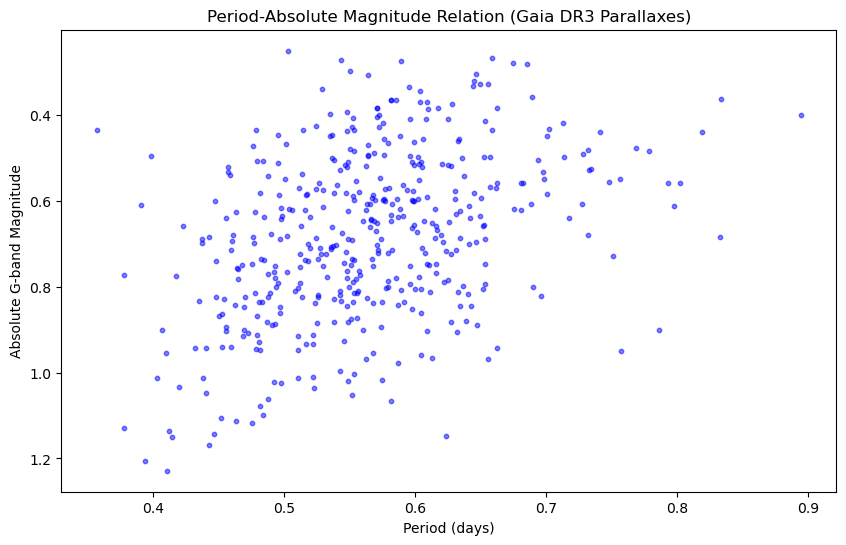

In [25]:
from astropy.table import join
# Joining the RR Lyrae data with the geometric distance estimates
joined_data = join(results1, results4, keys='source_id', join_type='inner')
# Calculating absolute magnitudes using Gaia DR3 parallaxes
joined_data['abs_mag_g'] = joined_data['phot_g_mean_mag_1'] + 5 + 5 * np.log10(joined_data['parallax_1']/1000)

# Plotting the period-absolute magnitude relation
plt.figure(figsize=(10, 6))
plt.scatter(joined_data['period'], joined_data['abs_mag_g'], s=10, color='blue', alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('Period (days)')
plt.ylabel('Absolute G-band Magnitude')
plt.title('Period-Absolute Magnitude Relation (Gaia DR3 Parallaxes)')
plt.show()

## Fitting Period-Luminosity Relation with M-H MCMC PART 1

In [26]:
periods = results4['period'] 
abs_mags = results4['abs_mag_g']

Acceptance rate: 0.5141


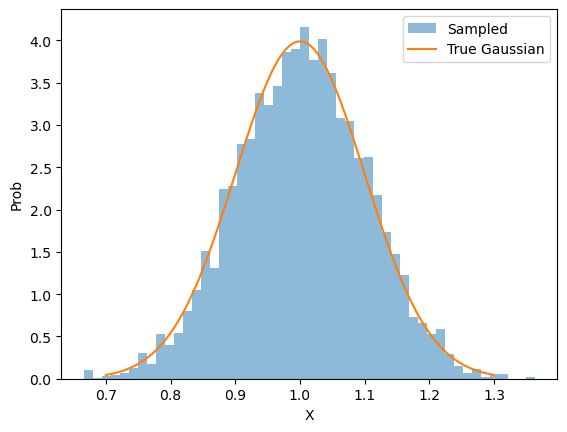

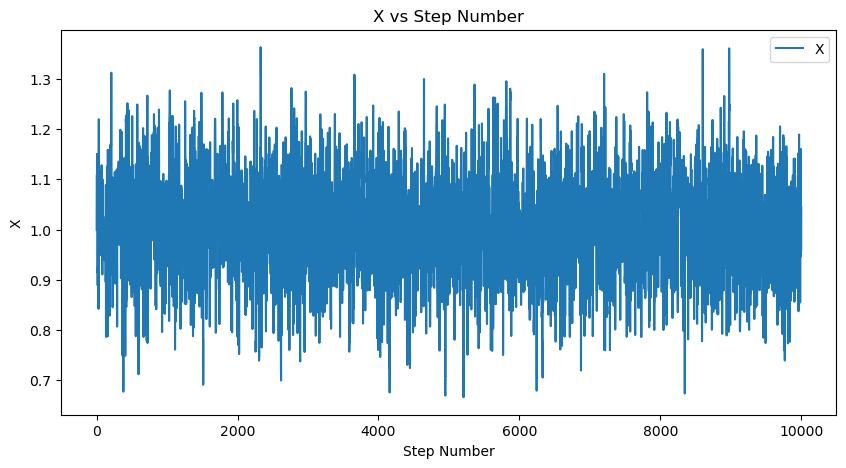

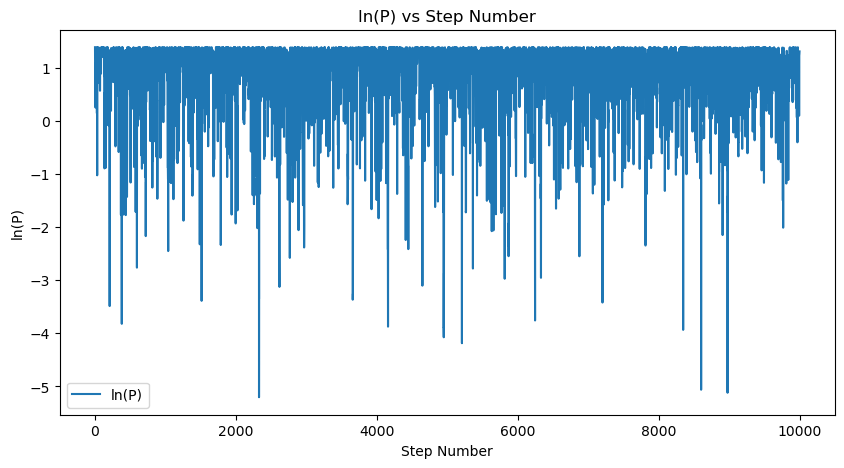

In [27]:


# Gaussian PDF
def gaussian_pdf(x, mu, sigma):
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((mu - x)**2) / (2 * sigma**2))

# Logarithm of the Gaussian PDF
def log_gaussian_pdf(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - ((mu - x)**2) / (2 * sigma**2)

# Metropolis-Hastings sampler
def mh_sampler(log_P, n_samples, proposal_width, init_params):
    samples = [init_params]
    log_probs = [log_P(init_params)]
    acceptance_count = 0

    for _ in range(n_samples):
        current_params = samples[-1]
        proposed_params = np.random.normal(current_params, proposal_width)
        log_acceptance_ratio = log_P(proposed_params) - log_P(current_params)

        if np.log(np.random.rand()) < log_acceptance_ratio:
            samples.append(proposed_params)
            log_probs.append(log_P(proposed_params))
            acceptance_count += 1
        else:
            samples.append(current_params)
            log_probs.append(log_P(current_params))

    acceptance_rate = acceptance_count / n_samples
    return np.array(samples), np.array(log_probs), acceptance_rate

 
mu = 1.0
sigma = 0.1
n_samples = 10000
proposal_width = 0.195
init_params = 1

samples, log_probs, acceptance_rate = mh_sampler(
    lambda x: log_gaussian_pdf(x, mu, sigma), 
    n_samples, 
    proposal_width, 
    init_params
)
print(f"Acceptance rate: {acceptance_rate}")


# Plotting samples
plt.hist(samples, bins=50, density=True, alpha=0.5, label='Sampled')
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, gaussian_pdf(x, mu, sigma), label='True Gaussian')
plt.xlabel("X")
plt.ylabel("Prob")
plt.legend()
plt.show()

# Plotting X vs step number
plt.figure(figsize=(10, 5))
plt.plot(samples, label='X')
plt.xlabel('Step Number')
plt.ylabel('X')
plt.title('X vs Step Number')
plt.legend()
plt.show()

# Plotting ln(P) vs step number
plt.figure(figsize=(10, 5))
plt.plot(log_probs, label='ln(P)')
plt.xlabel('Step Number')
plt.ylabel('ln(P)')
plt.title('ln(P) vs Step Number')
plt.legend()
plt.show()


## Fitting Period-Luminosity Relation with M-H MCMC PART 2

Acceptance rate: 0.5176


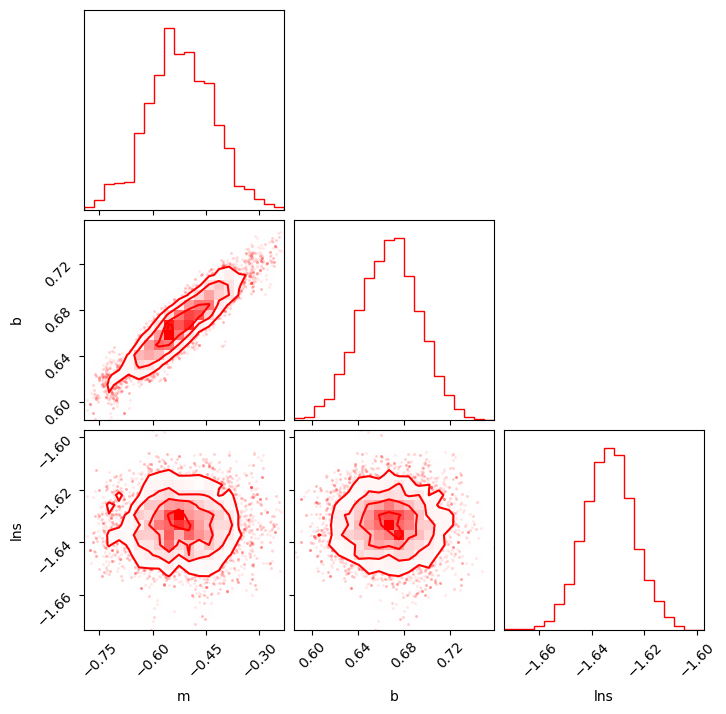

In [28]:


periods = results4['period']
abs_mags = results4['abs_mag_g']
abs_mag_err = results4['abs_mag_error']

# Likelihood function
def log_likelihood(params, periods, abs_mags, abs_mag_err):
    a, b, ln_sigma_scatter = params
    sigma_scatter = np.exp(ln_sigma_scatter)  
    model_mags = a * np.log10(periods) + b
    total_sigma = np.sqrt(sigma_scatter**2 + abs_mag_err**2)
    return -0.5 * np.sum(((abs_mags - model_mags) / total_sigma) ** 2)

prior_a_mean = -.4
prior_a_sd = 0.1
prior_b_mean = 0.5
prior_b_sd = 0.1

# Prior function with prior knowledge of parameters
def log_prior(params):
    a, b, ln_sigma_scatter = params
    sigma_scatter = np.exp(ln_sigma_scatter)  
    if sigma_scatter <= 0:  
        return -np.inf
    return -0.5 * ((a - prior_a_mean) / prior_a_sd)**2 \
           -0.5 * ((b - prior_b_mean) / prior_b_sd)**2 \
           -0.5 * ((ln_sigma_scatter - np.log(0.191)) / 0.01)**2  
# Posterior function
def log_posterior(params, periods, abs_mags, abs_mag_err):
    return log_prior(params) + log_likelihood(params, periods, abs_mags, abs_mag_err)

# Metropolis-Hastings sampler for the three-dimensional parameter space
def mh_sampler_3d(data, n_samples, proposal_width, init_params):
    samples = [init_params]
    acceptance_count = 0

    for _ in range(n_samples):
        current_params = samples[-1]
        proposed_params = np.random.normal(current_params, proposal_width)
        acceptance_ratio = np.exp(log_posterior(proposed_params, *data) - log_posterior(current_params, *data))

        if np.random.rand() < acceptance_ratio:
            samples.append(proposed_params)
            acceptance_count += 1
        else:
            samples.append(current_params)

    acceptance_rate = acceptance_count / n_samples
    return np.array(samples), acceptance_rate

# Running the sampler
n_samples = 10000
proposal_width = [.011, .011, .011]  
init_params = [-.4, 0.65, np.log(0.191)]  
data = (periods, abs_mags, abs_mag_err)
samples, acceptance_rate = mh_sampler_3d(data, n_samples, proposal_width, init_params)

print(f"Acceptance rate: {acceptance_rate}")
fig = corner.corner(samples, labels=["m", "b", "lns"], color='red')
plt.show()

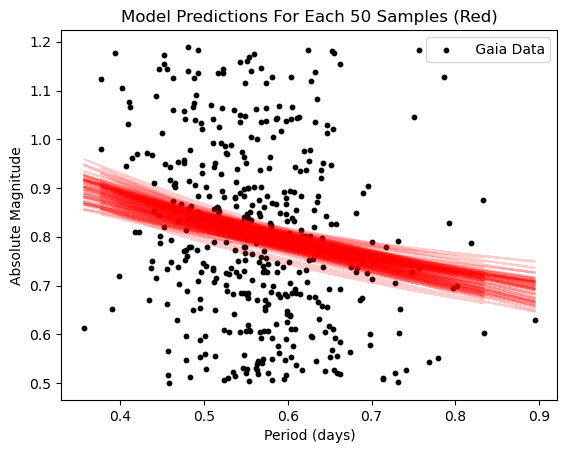

In [29]:
# Random 50 samples
np.random.seed(42)  
sample_indices = np.random.choice(len(samples), 50, replace=False)
samples_array = np.array(samples)
selected_samples = samples_array[sample_indices]


# Plotting gaia data
plt.scatter(periods, abs_mags, s=10, color='black', label=' Gaia Data')

# Plotting the model predictions for each selected sample
for sample in selected_samples:
    a, b, _ = sample
    model_mags = a * np.log10(periods) + b
    plt.plot(periods, model_mags, color='red', alpha=0.2) 

plt.title("Model Predictions For Each 50 Samples (Red)")
plt.xlabel('Period (days)')
plt.ylabel('Absolute Magnitude')
plt.legend()
plt.show()


## Fitting Period-Luminosity Relation with Model using Pymc

In [30]:
import pymc as pm
import arviz as az

prior_sigma_scatter_mean =.2

periods = np.ma.filled(results4['period'], fill_value=np.nan)
abs_mags = np.ma.filled(results4['abs_mag_g'], fill_value=np.nan)
abs_mag_err = np.ma.filled(results4['abs_mag_error'], fill_value=np.nan)


In [31]:
# Likelihood function compatible with PyMC3
def log_likelihood(params, periods, abs_mags, abs_mag_err):
    a, b, log_sigma_scatter = params
    sigma_scatter = pm.math.exp(log_sigma_scatter)  
    model_mags = a * pm.math.log(periods) + b
    total_sigma = pm.math.sqrt(sigma_scatter**2 + abs_mag_err**2)
    return -0.5 * pm.math.sum(((abs_mags - model_mags) / total_sigma) ** 2)

with pm.Model() as model:
    # Priors for parameters
    a = pm.Normal('a', mu=prior_a_mean, sigma=prior_a_sd)
    b = pm.Normal('b', mu=prior_b_mean, sigma=prior_b_sd)
    log_sigma_scatter = pm.Normal('log_sigma_scatter', mu=np.log(prior_sigma_scatter_mean), sigma=.01)

    # Expected absolute magnitude (theoretical model)
    expected_abs_mag = a * pm.math.log(periods) + b

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=expected_abs_mag, sigma=pm.math.exp(log_sigma_scatter) * np.sqrt(1 + (abs_mag_err / pm.math.exp(log_sigma_scatter))**2), observed=abs_mags)

    # Potential term for the likelihood function
    potential = pm.Potential('likelihood', log_likelihood([a, b, log_sigma_scatter], periods, abs_mags, abs_mag_err))
    
    # Drawing samples from the posterior using the NUTS sampler
    trace = pm.sample(draws=1000, tune=500, target_accept=0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, log_sigma_scatter]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.


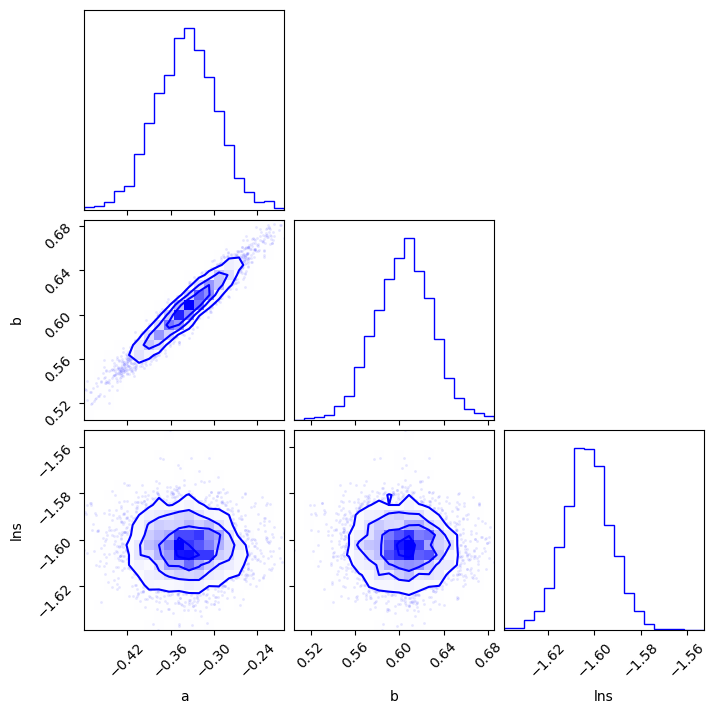

In [32]:
fig = corner.corner(trace, labels=["a", "b", "lns"], color="blue", label = "model")

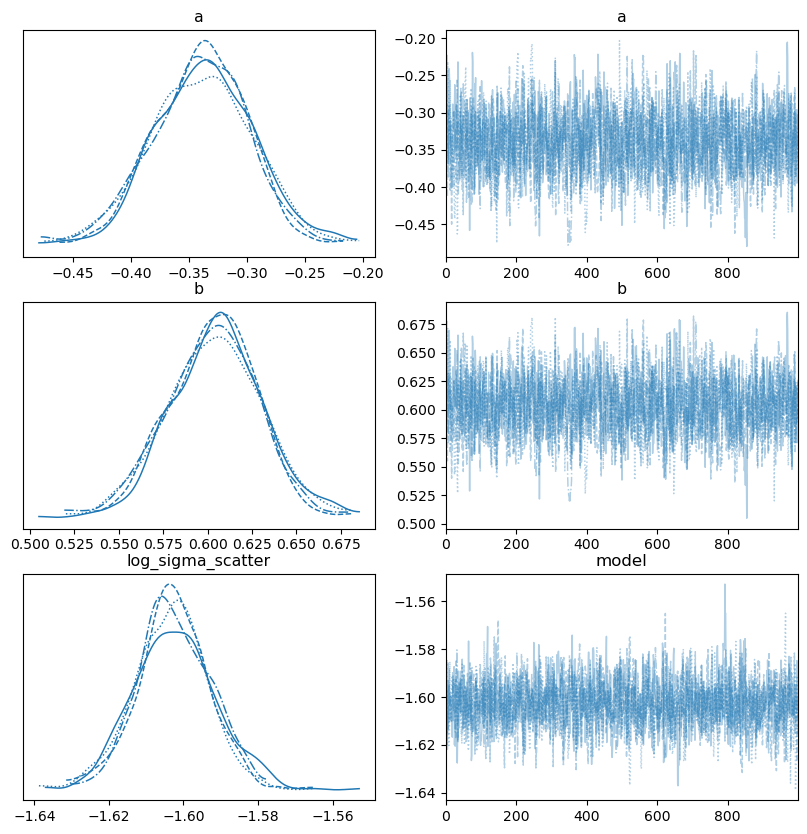

In [33]:
# Posterior analysis
az.plot_trace(trace, figsize = (10,10))
plt.title("model")
plt.show()

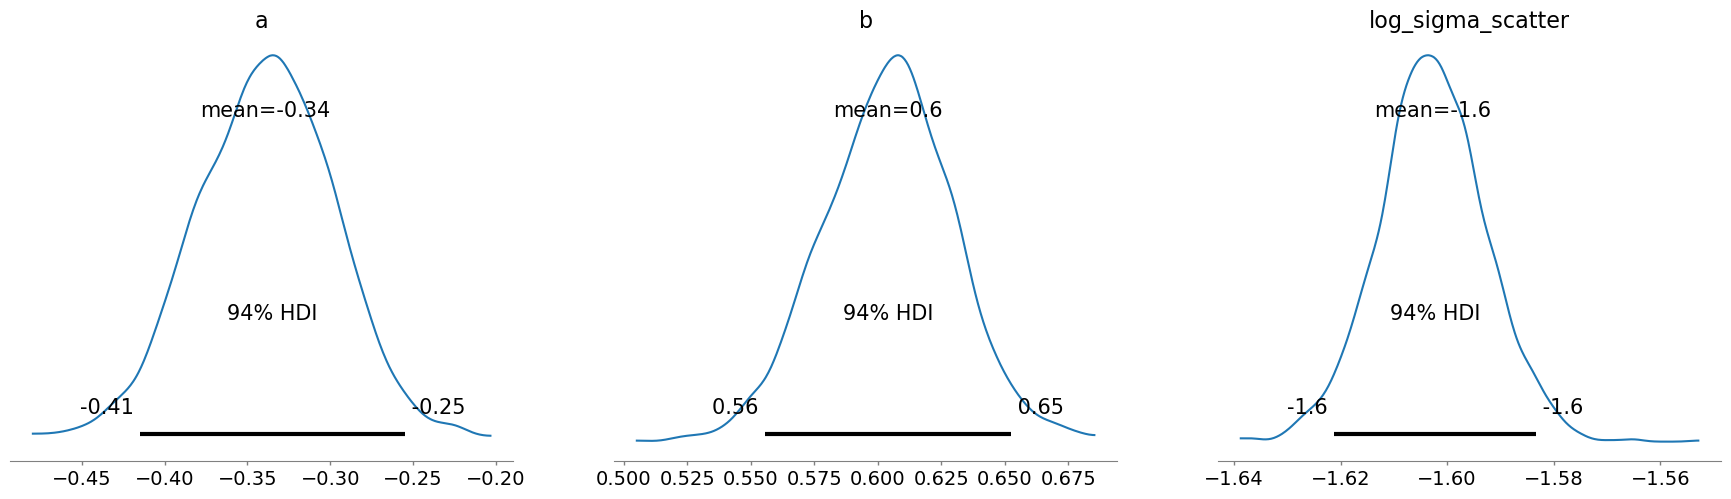

In [34]:
# Plotting the posterior distributions
pm.plot_posterior(trace)
plt.show()

## Fitting Period-Luminosity Relation with Explicit Likelihood + PYMC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, log_sigma_scatter]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.


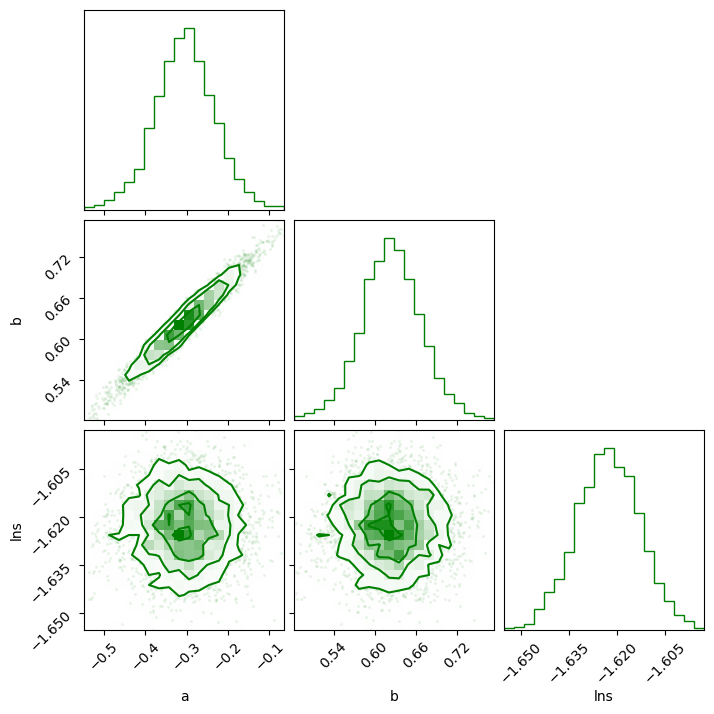

In [35]:
with pm.Model() as model:
    # Priors for parameters
    a = pm.Normal('a', mu=0, sigma=10)
    b = pm.Normal('b', mu=0, sigma=10)
    log_sigma_scatter = pm.Normal('log_sigma_scatter', mu=np.log(0.2), sigma=.01)

    # Expected absolute magnitude (theoretical model)
    expected_abs_mag = a * pm.math.log(periods) + b

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=expected_abs_mag, sigma=pm.math.sqrt(pm.math.exp(log_sigma_scatter)**2 + abs_mag_err**2), observed=abs_mags)

    # Drawing samples from the posterior using the NUTS sampler
    traceii = pm.sample(draws=1000, tune=500, target_accept=0.95)

fig = corner.corner(traceii, labels=["a", "b", "lns"], color="green", label = "model")

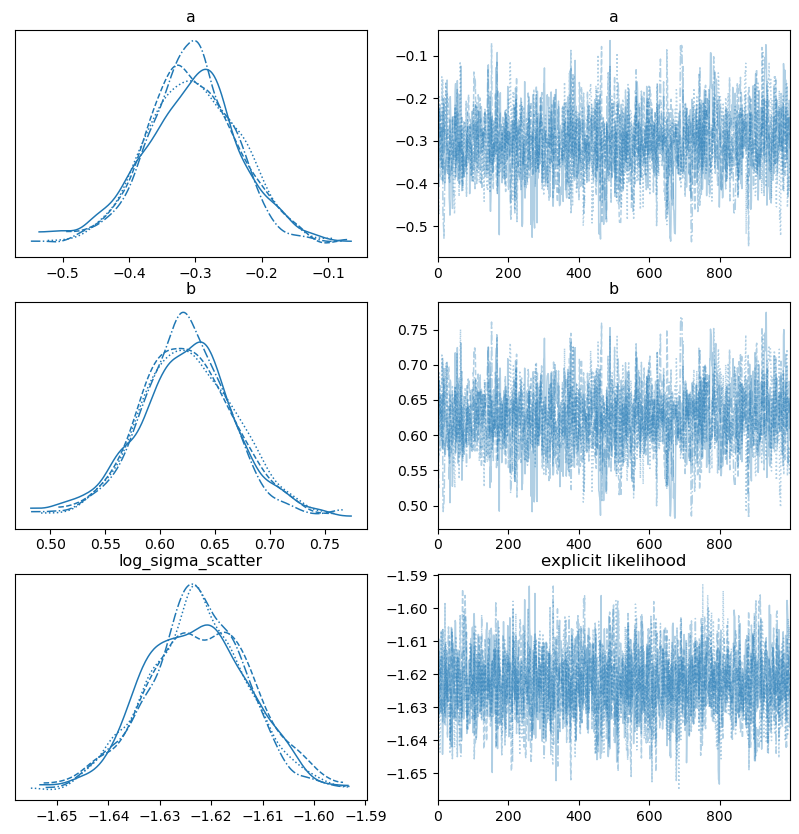

In [36]:
az.plot_trace(traceii, figsize = (10,10))
plt.title("explicit likelihood")
plt.show()

array([<AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'b'}>,
       <AxesSubplot:title={'center':'log_sigma_scatter'}>], dtype=object)

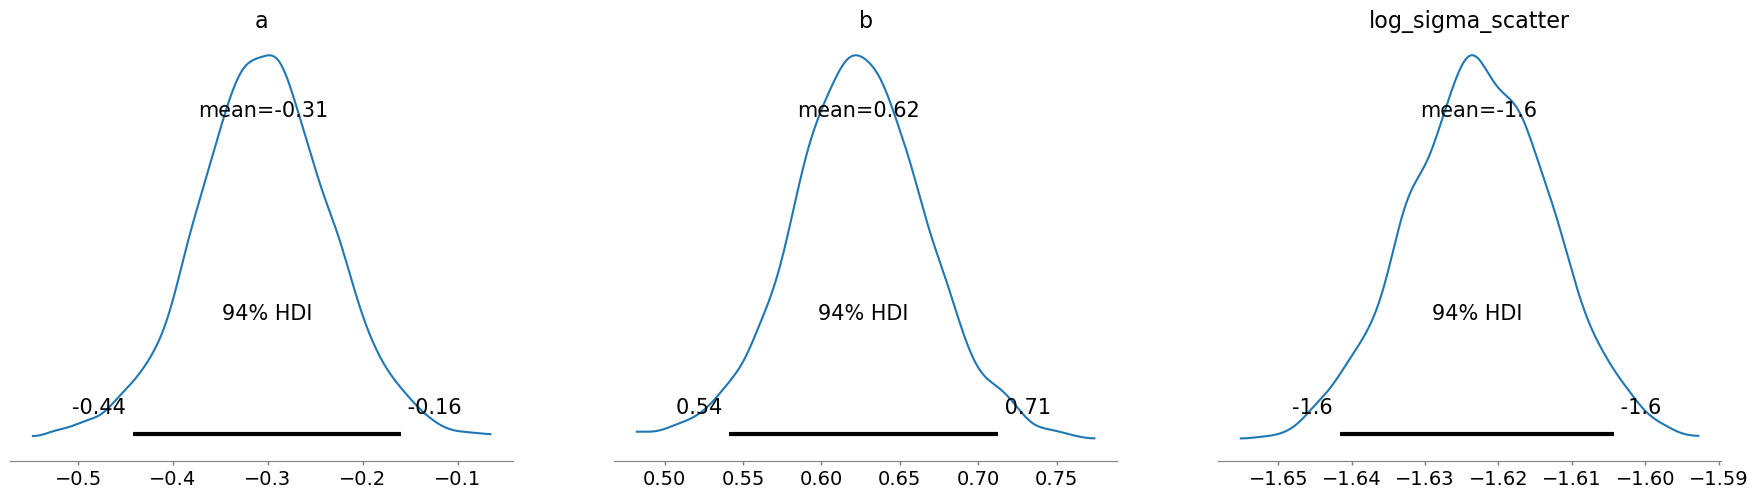

In [37]:
pm.plot_posterior(traceii)

## COMPARISON using Corner Plots of ALL 3 Models

In [38]:
samples_ii = trace.posterior.to_dataframe().reset_index().drop(columns=['chain', 'draw'])
samples_iii = traceii.posterior.to_dataframe().reset_index().drop(columns=['chain', 'draw'])


df_ii = pd.DataFrame(samples_ii)
df_iii = pd.DataFrame(samples_iii)

relevant_columns = ['a', 'b', 'log_sigma_scatter']
df_ii = df_ii[relevant_columns]
df_iii = df_iii[relevant_columns]

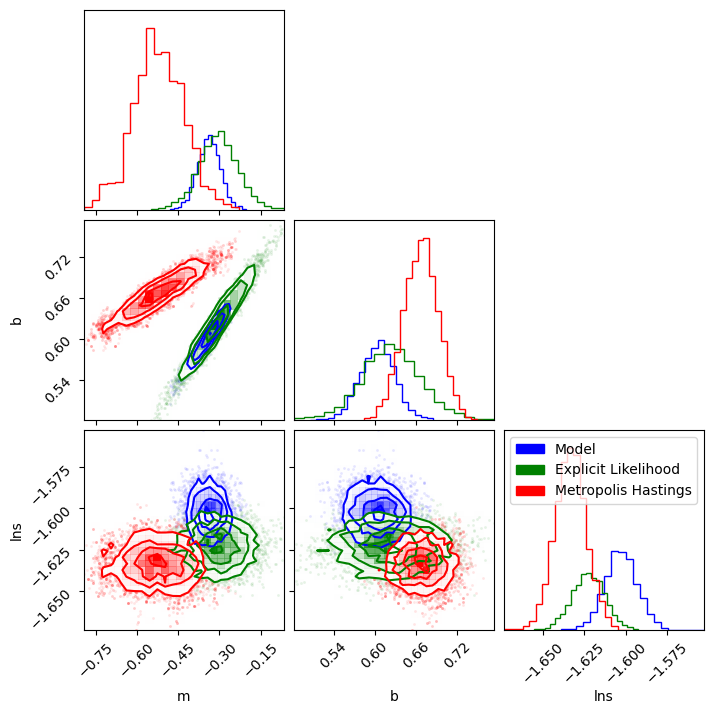

In [39]:
import matplotlib.patches as mpatches

# corner plot 
fig = corner.corner(df_ii, labels=["m", "b", "lns"], color="blue")
corner.corner(df_iii, labels=["m", "b", "lns"], color="green", fig=fig)
corner.corner(samples, labels=["m", "b", "lns"], color="red", fig=fig)


blue_patch = mpatches.Patch(color='blue', label='Model')
green_patch = mpatches.Patch(color='green', label='Explicit Likelihood')
red_patch = mpatches.Patch(color='red', label='Metropolis Hastings')

plt.legend(handles=[blue_patch, green_patch, red_patch])


plt.show()


## Deriving Period-Color Relation

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
INFO:pymc.sampling.mcmc:NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

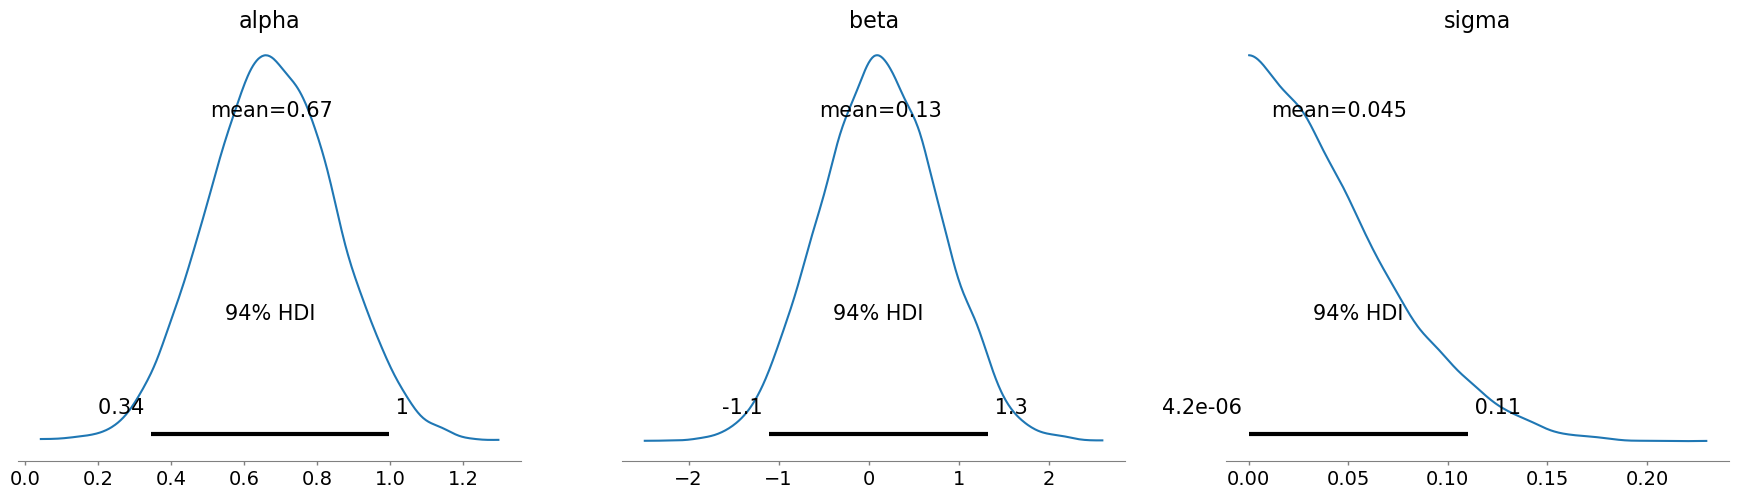

In [40]:
import pymc as pm

joined_data['gbp-grp'] = joined_data['phot_bp_mean_mag_1']-joined_data['phot_rp_mean_mag_1']


periods = np.ma.filled(joined_data['period'], fill_value=np.nan) # Periods of RR Lyrae stars
gbp_minus_grp = np.ma.filled(joined_data['gbp-grp'], fill_value=np.nan) # GBP - GRP color
color_err = np.ma.filled(joined_data['phot_bp_rp_excess_factor'], fill_value=np.nan) # Uncertainties in color

with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected color
    expected_color = alpha + beta * np.log10(periods)

    # Standard deviation for the likelihood
    sigma_total = pm.math.sqrt(sigma**2 + color_err**2)

    # Likelihood
    pm.Normal('obs', mu=expected_color, sigma=sigma_total, observed=gbp_minus_grp)

    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

# Plotting the posterior distributions
pm.plot_posterior(trace)


## NEXT: Full Gaia RR Lyrae Catalog Download

In [41]:
query3 = """
SELECT
rrlyrae.source_id,
source.source_id,
source.phot_bp_mean_mag,
source.phot_rp_mean_mag,
source.l,
source.b,
source.phot_g_mean_flux_over_error,
source.phot_bp_rp_excess_factor,
source.bp_rp,
source.mh_gspphot,
rrlyrae.metallicity,
rrlyrae.G_absorption,
rrlyrae.pf

FROM
    gaiadr3.vari_rrlyrae AS rrlyrae
JOIN
    gaiadr3.gaia_source AS source
ON
    rrlyrae.source_id = source.source_id
 """
job3 = Gaia.launch_job_async(query3)
results3 = job3.get_results()
print(results3)

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
     source_id          source_id_2     ... G_absorption          pf        
                                        ...     mag               d         
------------------- ------------------- ... ------------ -------------------
 244893954275107200  244893954275107200 ...           --                  --
 245002531050576896  245002531050576896 ...     1.122552  0.5205123049162365
 245251978451433728  245251978451433728 ...           --                  --
 245293416297967360  245293416297967360 ...           --                  --
 245435906133523072  245435906133523072 ...           --                  --
 245464806968150400  245464806968150400 ...           --                  --
 245504251951140864  245504251951140864 ...    2.0499203  0.5071152853230051
5712016786666075776 5712016786666075776 ...           --  0.5894468159499638
 245806617648715008  245806617648715008 ...           --                  --
 245823861938360064  24582

## Calculating Color Excess and G-band Extinction USING derived parameters from Pymc

In [42]:

GBP_observed = results3['phot_bp_mean_mag']
GRP_observed = results3['phot_rp_mean_mag']
colors_period = results3['pf']

# Model for intrinsic color for RR Lyrae stars
GBP_GRP_intrinsic = .67 + .11 * np.log(colors_period)


# Calculating color excess
color_excess = GBP_observed - GRP_observed - GBP_GRP_intrinsic

# Calculating G-band extinction
RG = 2.0
AG = RG * color_excess

# New Column
results3['color_excess'] = color_excess
results3['AG'] = AG

# Display the updated DataFrame
print(results3[['source_id', 'color_excess', 'AG']])

     source_id          color_excess            AG        
------------------- ------------------- ------------------
 244893954275107200                  --                 --
 245002531050576896  0.5318599466350564 1.0637198932701128
 245251978451433728                  --                 --
 245293416297967360                  --                 --
 245435906133523072                  --                 --
 245464806968150400                  --                 --
 245504251951140864  0.7664739345162207 1.5329478690324414
5712016786666075776  1.1960250949787594  2.392050189957519
 245806617648715008                  --                 --
 245823861938360064  0.6355839213621689 1.2711678427243378
                ...                 ...                ...
5917403497163999232                  --                 --
5917407173655038336                  --                 --
5917418134421212288  0.0297131031004485  0.059426206200897
5917421329878084224  1.8271662258919763 3.65433245178395

## Plotting 2-D Map of Color Excess

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/function_base.py:3710: RuntimeWarning: invalid value encountered in divide
  return sin(y)/y


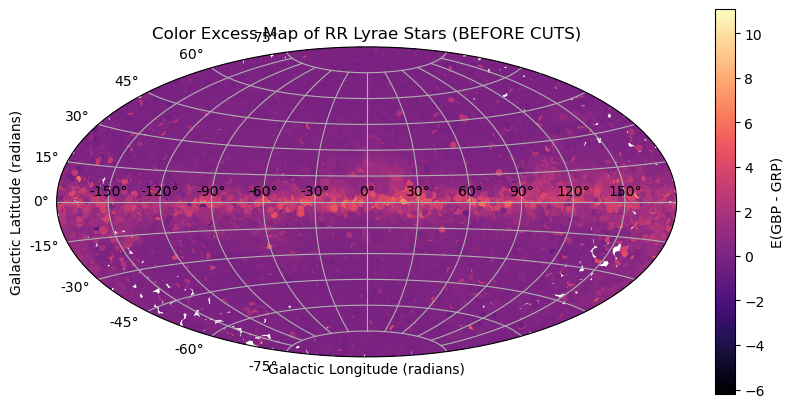

In [44]:
l = results3['l']
b = results3['b']
E_GBP_GRP = results3['AG']


l = l % 360  
l[l > 180] -= 360  # Shift to be between -180 and 180 for Aitoff

# Converting to radians for Aitoff projection
l_rad_adj = np.radians(l)
b_rad = np.radians(b)

#the plot
plt.figure(figsize=(10, 5))
plt.subplot(111, projection="aitoff")
sc = plt.scatter(l_rad_adj, b_rad, c=E_GBP_GRP, cmap='magma', alpha=1, s=15)
plt.colorbar(sc, label='E(GBP - GRP)')
plt.title('Color Excess Map of RR Lyrae Stars (BEFORE CUTS)')
plt.xlabel('Galactic Longitude (radians)')
plt.ylabel('Galactic Latitude (radians)')
plt.grid(True)

plt.show()

Equation for excess factor cut: Gaia Collaboration, Brown, A.G.A., Vallenari, A., Prusti, T., de Bruijne, J.H.J., et al. (2018). Gaia Data Release 2. Summary of the contents and survey properties. Astronomy & Astrophysics, 616, A1. DOI: 10.1051/0004-6361/201833051

## Applying Extinction Cuts

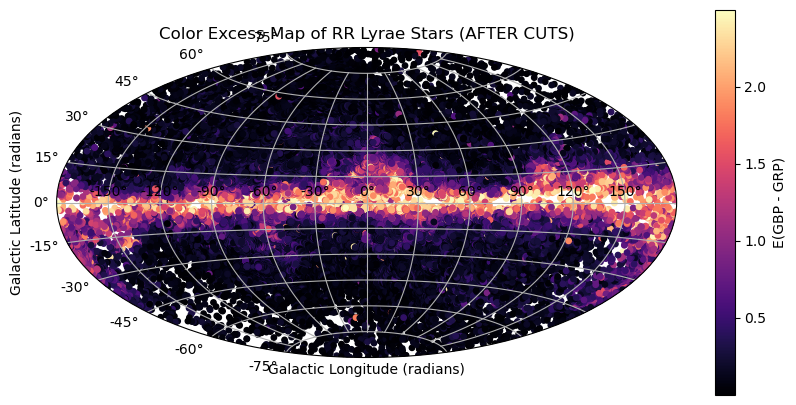

In [45]:

SNR_cut = 10  # SNR cut
excess_factor_cut = 1.3 + 0.06 * results3['bp_rp']**2  # cut based on BP/RP excess

# Applying the cuts
quality_mask = (results3['phot_g_mean_flux_over_error'] > SNR_cut) & \
               (results3['phot_bp_rp_excess_factor'] < excess_factor_cut)

filtered_results = results3[quality_mask]

# Updating the plot with filtered data
l_filtered = filtered_results['l']
l_filtered = l_filtered % 360  
l_filtered[l_filtered > 180] -= 360  # Shift to be between -180 and 180 for Aitoff
b_filtered = filtered_results['b']
E_GBP_GRP_filtered = filtered_results['AG']


# DataFrame with color excess and Galactic coordinates
df1 = pd.DataFrame({
    'ebv': E_GBP_GRP_filtered,
    'l': l_filtered,
    'b': b_filtered
})

# Further Cuts
filtered_df = df1[(df1['ebv'] >= 0) & (df1['ebv'] <= 2.5)]

# Accessing the filtered data
filtered_ebv = filtered_df['ebv']
filtered_l = filtered_df['l']
filtered_b = filtered_df['b']


l_rad = np.radians(filtered_l)
b_rad = np.radians(filtered_b)

plt.figure(figsize=(10, 5))
plt.subplot(111, projection="aitoff")
sc = plt.scatter(l_rad, b_rad, c=filtered_ebv, cmap='magma', alpha=1, s=15)
plt.colorbar(sc, label='E(GBP - GRP)')
plt.title('Color Excess Map of RR Lyrae Stars (AFTER CUTS)')
plt.xlabel('Galactic Longitude (radians)')
plt.ylabel('Galactic Latitude (radians)')
plt.grid(True)

plt.show()


## Creating Comparison with SFD Dust Map

Schlegel, Finkbeiner, and Davis 1998. https://arxiv.org/abs/astro-ph/9710327

Configuration file not found:

    /home/jovyan/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


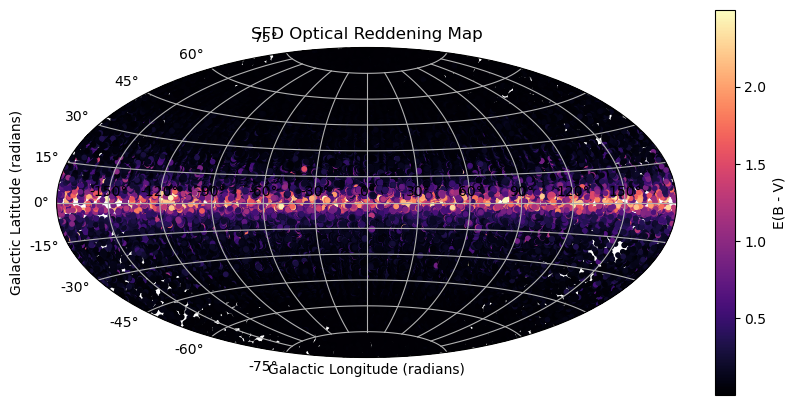

In [46]:
import dustmaps.sfd
dustmaps.sfd.fetch()
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
import astropy.units as u


coords = SkyCoord(l_filtered, b_filtered, unit = u.rad, frame='galactic')

# Query SFD dust map
sfd = SFDQuery()
ebv_sfd = sfd(coords)


# DataFrame with color excess and Galactic coordinates
df2 = pd.DataFrame({
    'ebv_sfd': ebv_sfd,
    'l': l_filtered,
    'b': b_filtered
})


filtered_df = df2[(df2['ebv_sfd'] >= -3) & (df2['ebv_sfd'] <= 2.5)]

# Accessing the filtered data
filtered_ebv_sfd = filtered_df['ebv_sfd']
filtered_l = filtered_df['l']
filtered_b = filtered_df['b']


l_rad = np.radians(filtered_l)
b_rad = np.radians(filtered_b)

# Plotting the SFD map
plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='aitoff')
sc = ax.scatter(l_rad,b_rad, c=filtered_ebv_sfd, cmap='magma', alpha=1, s=10)
plt.colorbar(sc, label='E(B - V)')
plt.title('SFD Optical Reddening Map')
ax.set_xlabel('Galactic Longitude (radians)')
ax.set_ylabel('Galactic Latitude (radians)')
plt.grid(True)
plt.show()